1. attention各层之间关系
    画曲线，平均值？最大值？
    消融实验

    神经：时间序列-平均-每句话-每个脑区100*1对句子的平均响应
    
2. 基于bert或gpt2 model的attention各head的关系（transformer）
    head: 每个头使用不同的权重矩阵。这些不同头的输出向量最后被拼接起来，并通过一个线性层进行处理。
    head在层内关系

3. 语义节点与词的关系，语义节点与单向、双向attention的关系
    信息流向：在单向注意力中，信息只能从左到右流动（或从序列的开始到结束），而在双向注意力中，信息可以在任何方向上流动。
    适用场景：单向注意力更适合于生成任务，如语言模型、文本生成等，因为它模拟了自然语言生成的顺序性。双向注意力则更适合于理解任务，如文本分类、问答等，因为它能够综合考虑上下文的全部信息。
4. bert/gpt2 model中是否需要特殊符号
5. 基于transformer的模型能否改变attention的输出形式，或者根据数学原理自己写函数manipulate原始输出矩阵


6. 小明停车。他走进餐馆，吃了一碗面。
   小明停车。他走进餐馆。他吃了一碗面。
   1）整句输入
   2）+ [SEP]

In [2]:
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel, GPT2LMHeadModel
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib
from bertviz import head_view, model_view

1. 尝试构建基于[CLS]的Sentence-Level Attention Model

['[CLS]', '[CLS]', '穿', '过', '巴', '黎', '的', '大', '街', '，', '我', '来', '到', '了', '一', '家', '传', '统', '的', '法', '式', '餐', '厅', '，', '店', '门', '前', '摆', '放', '了', '薰', '衣', '草', '和', '干', '花', '[SEP]', '[CLS]', '我', '选', '择', '了', '一', '个', '能', '看', '到', '街', '景', '的', '位', '置', '坐', '下', '，', '旁', '边', '正', '好', '是', '一', '堵', '涂', '鸦', '墙', '[SEP]', '[CLS]', '当', '我', '翻', '看', '菜', '单', '时', '，', '服', '务', '员', '热', '情', '地', '为', '我', '推', '荐', '了', '鹅', '肝', '和', '鹅', '掌', '[SEP]', '[CLS]', '很', '快', '，', '诱', '人', '的', '美', '食', '被', '送', '到', '我', '的', '眼', '前', '，', '配', '上', '一', '杯', '红', '酒', '，', '不', '失', '为', '一', '种', '享', '受', '[SEP]', '[SEP]']
1.0


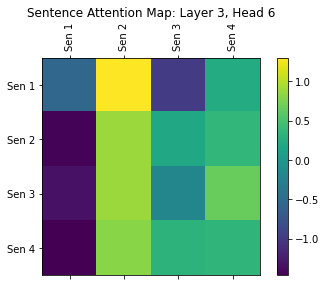

'\n# 初始化句子间注意力矩阵\nsentence_attention_avg = torch.zeros((num_sentences, num_sentences))\n\n# 获取每个句子的开始和结束位置\nsep_positions = [i for i, token in enumerate(tokens) if token == "[SEP]"]\nsentence_boundaries = list(zip(cls_positions[1:], sep_positions))\n\n# 填充句子级平均注意力矩阵\nfor i, (start_i, end_i) in enumerate(sentence_boundaries):\n    for j, (start_j, end_j) in enumerate(sentence_boundaries):\n        # 计算i句子到j句子的平均注意力得分\n        attention_slice = attention[start_i:end_i+1, start_j:end_j+1]\n        avg_attention = attention_slice.mean()\n        sentence_attention_avg[i, j] = avg_attention\n\n# 计算平均值和标准差\nmean = torch.mean(sentence_attention_avg, dim=-1, keepdim=True)\nstd = torch.std(sentence_attention_avg, dim=-1, keepdim=True)\n\n# 进行Z-score归一化\nsentence_attention_avg_normalized = (sentence_attention_avg - mean) / std\n\nprint(sentence_attention_avg_normalized)\n\n# 可视化\nfig, ax = plt.subplots()\ncax = ax.matshow(sentence_attention_avg_normalized.detach().numpy(), cmap=\'viridis\')\nfig

In [173]:
# 设置matplotlib字体以支持中文
#matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 或者您可以使用其他支持中文的字体
#matplotlib.rcParams['font.family']='sans-serif'

# 初始化分词器和模型
# 初始化分词器和模型
tokenizer = BertTokenizer.from_pretrained('F:/project/Attention/bert-base-chinese')
model = BertModel.from_pretrained('F:/project/Attention/bert-base-chinese', output_attentions=True).eval()
# 编码整个语篇
text = "穿过巴黎的大街，我来到了一家传统的法式餐厅，店门前摆放了薰衣草和干花。我选择了一个能看到街景的位置坐下，旁边正好是一堵涂鸦墙。当我翻看菜单时，服务员热情地为我推荐了鹅肝和鹅掌。很快，诱人的美食被送到我的眼前，配上一杯红酒，不失为一种享受。"
sentences = text.split('。')[:-1]  # 分割句子
input_text = "[CLS] " + "[SEP] [CLS] ".join(sentences) + "[SEP]"  # 构造输入

# 编码文本
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)



outputs = model(**inputs)

input_ids = inputs['input_ids']
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print(tokens)
# Assume we're looking at the first layer and first head for demonstration
layer = 2
head = 5

# 提取特定的注意力矩阵
attention = outputs.attentions[layer][0, head, :, :]  # 正确索引attention矩阵 

print(np.sum(attention[14,:].detach().numpy()))

# 识别[CLS]标记位置并进行调整
cls_positions = [pos for pos, token in enumerate(tokens) if token == "[CLS]"]

# 计算真正的句子数目，考虑到最开始的[CLS]代表整个文本
num_sentences = len(cls_positions) - 1
sentence_attention = torch.zeros((num_sentences, num_sentences))


# 填充句子级注意力矩阵
for i in range(num_sentences):
    for j in range(num_sentences):
        # 注意：我们通过[CLS]标记来代表每个句子
        # 需要+1来跳过序列开头的全局[CLS]标记
        sentence_attention[i, j] = attention[cls_positions[i + 1], cls_positions[j + 1]]

# 计算平均值和标准差
mean = torch.mean(sentence_attention, dim=-1, keepdim=True)
std = torch.std(sentence_attention, dim=-1, keepdim=True)

# 进行Z-score归一化
sentence_attention_normalized = (sentence_attention - mean) / std

# 可视化
fig, ax = plt.subplots()
cax = ax.matshow(sentence_attention_normalized.detach().numpy(), cmap='viridis')
fig.colorbar(cax)

# 设置标签以提高可读性
sentence_labels = ['Sen ' + str(i+1) for i in range(num_sentences)]
ax.set_xticks(range(num_sentences))
ax.set_yticks(range(num_sentences))
ax.set_xticklabels(sentence_labels, rotation=90)
ax.set_yticklabels(sentence_labels)

plt.title(f'Sentence Attention Map: Layer {layer+1}, Head {head+1}')
plt.show()

'''
# 初始化句子间注意力矩阵
sentence_attention_avg = torch.zeros((num_sentences, num_sentences))

# 获取每个句子的开始和结束位置
sep_positions = [i for i, token in enumerate(tokens) if token == "[SEP]"]
sentence_boundaries = list(zip(cls_positions[1:], sep_positions))

# 填充句子级平均注意力矩阵
for i, (start_i, end_i) in enumerate(sentence_boundaries):
    for j, (start_j, end_j) in enumerate(sentence_boundaries):
        # 计算i句子到j句子的平均注意力得分
        attention_slice = attention[start_i:end_i+1, start_j:end_j+1]
        avg_attention = attention_slice.mean()
        sentence_attention_avg[i, j] = avg_attention

# 计算平均值和标准差
mean = torch.mean(sentence_attention_avg, dim=-1, keepdim=True)
std = torch.std(sentence_attention_avg, dim=-1, keepdim=True)

# 进行Z-score归一化
sentence_attention_avg_normalized = (sentence_attention_avg - mean) / std

print(sentence_attention_avg_normalized)

# 可视化
fig, ax = plt.subplots()
cax = ax.matshow(sentence_attention_avg_normalized.detach().numpy(), cmap='viridis')
fig.colorbar(cax)

# 设置标签以提高可读性
sentence_labels = ['句子 ' + str(i+1) for i in range(num_sentences)]
ax.set_xticks(range(num_sentences))
ax.set_yticks(range(num_sentences))
ax.set_xticklabels(sentence_labels, rotation=90)
ax.set_yticklabels(sentence_labels)

plt.title(f'Layer {layer+1}, Head {head+1} 的句子级注意力矩阵')
plt.show()
'''

1.1 多sample的[CLS]Sentence-Level Attention方法

In [2]:

# 设置matplotlib字体以支持中文
#matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 或者您可以使用其他支持中文的字体
#matplotlib.rcParams['font.family'] = 'sans-serif'

# 初始化分词器和模型
tokenizer = BertTokenizer.from_pretrained('F:/project/Attention/bert-base-chinese')
model = BertModel.from_pretrained('F:/project/Attention/bert-base-chinese', output_attentions=True).eval()

# 读取语料
with open("F:/project/Attention/corpus.txt", "r", encoding="utf-8") as file:
    corpus = [line.strip() for line in file.readlines()]
  
corpus = corpus[10:]
# 准备画布
fig, axs = plt.subplots(len(corpus), 12, figsize=(30, 30), sharex='col', sharey='row',
                        gridspec_kw={'wspace':0.5, 'hspace':0.2, 'right':0.85})

# 累积所有子图的attention矩阵，用于确定colorbar的范围
all_attentions = []

for corpus_index, text in enumerate(corpus):
    sentences = text.split('。')[:-1]
    input_text = "[CLS] " + "[SEP] [CLS] ".join(sentences) + "[SEP]"

    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)

    input_ids = inputs['input_ids']
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    cls_positions = [pos for pos, token in enumerate(tokens) if token == "[CLS]"]
    num_sentences = len(cls_positions) - 1

    for layer in range(12):
        all_heads_attention = outputs.attentions[layer][0].mean(dim=0)
        sentence_attention = torch.zeros((num_sentences, num_sentences))

        for i in range(num_sentences):
            for j in range(num_sentences):
                sentence_attention[i, j] = all_heads_attention[cls_positions[i + 1], cls_positions[j + 1]]
        
        # 计算平均值和标准差
        #mean = torch.mean(sentence_attention, dim=-1, keepdim=True)
        #std = torch.std(sentence_attention, dim=-1, keepdim=True)


        #mean = torch.mean(sentence_attention)
        #std = torch.std(sentence_attention)

        # 进行Z-score归一化
        #sentence_attention_normalized = (sentence_attention - mean) / std
        
        all_attentions.append(sentence_attention)
        print(corpus_index, layer)
        
        ax = axs[corpus_index, layer]
        im = ax.matshow(sentence_attention.detach().numpy(), cmap='viridis')
        if layer == 0:
            ax.set_yticks(range(num_sentences))
        if corpus_index == 0:
            ax.set_title(f'Layer {layer+1}')

# 创建一个大colorbar适用于所有子图
cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])  # 适当调整colorbar的位置和大小
fig.colorbar(im, cax=cbar_ax)

#plt.savefig('all_attention_visualization.png')  # 保存图像
plt.close(fig)  # 如果不需要在Jupyter等环境中显示，可以关闭图形以节省资源



['[CLS]', '[CLS]', '日', '语', '的', '发', '音', '相', '对', '简', '单', '，', '五', '十', '音', '为', '初', '学', '者', '提', '供', '了', '明', '确', '的', '音', '节', '结', '构', '指', '导', '，', '但', '它', '多', '变', '的', '声', '调', '可', '能', '会', '造', '成', '一', '些', '困', '惑', '[SEP]', '[CLS]', '在', '语', '法', '上', '，', '其', '主', '谓', '宾', '的', '顺', '序', '与', '许', '多', '其', '他', '语', '言', '不', '同', '，', '使', '得', '学', '习', '者', '需', '要', '经', '常', '调', '整', '他', '们', '的', '思', '维', '方', '式', '进', '行', '理', '解', '[SEP]', '[CLS]', '为', '了', '真', '正', '掌', '握', '这', '门', '语', '言', '，', '可', '以', '考', '虑', '参', '加', '日', '本', '茶', '道', '或', '武', '道', '课', '程', '、', '参', '与', '日', '语', '语', '言', '角', '活', '动', '或', '与', '日', '本', '笔', '友', '交', '流', '[SEP]', '[CLS]', '日', '语', '，', '是', '探', '索', '和', '体', '验', '日', '本', '丰', '富', '文', '化', '的', '桥', '梁', '[SEP]', '[SEP]']
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
['[CLS]', '[CLS]', '意', '大', '利', '语', '的', '发', '音', '以', '其', '音', '韵', '美', '和', '情', '感', '丰', 

In [54]:
def transform_matrix(matrix):
    tril_indices = np.tril_indices_from(matrix, k=1)
    transformed_matrix = np.full(matrix.shape, np.nan)  # 创建一个填充了NaN的矩阵
    transformed_matrix[tril_indices] = matrix[tril_indices]  # 只填充对角线和下三角
    return transformed_matrix

cut_matrices = []

for matrix in all_attentions:
    matrix = matrix.detach().numpy()
    cut_matrix = transform_matrix(matrix)
    cut_matrices.append(cut_matrix)

print(cut_matrices[0])


flattened_matrices = []

for matrix in cut_matrices:
    # 将每个矩阵拉平
    flattened_matrix = matrix.flatten()
    valid_indices = ~np.isnan(flattened_matrix) 
    mean = np.mean(flattened_matrix[valid_indices])
    std = np.std(flattened_matrix[valid_indices])
    final = (flattened_matrix[valid_indices] - mean) / std
    flattened_matrices.append(final)

# 将列表转换为numpy数组
flattened_matrices = np.array(flattened_matrices)

# 现在 flattened_matrices 是形状为 (120, n_features) 的数组
# 其中 n_samples 为 120 (10个语料 * 12个层)

[[       nan        nan        nan        nan]
 [0.07622111        nan        nan        nan]
 [0.01982554 0.02821391        nan        nan]
 [0.02571946 0.03153479 0.12146604        nan]]


In [11]:
print(flattened_matrices[0])

[ 2.19943212 -0.39573806 -0.71373825 -0.18997028 -0.61641358 -0.28357194]


画20*20大矩阵

In [43]:
from scipy.stats import spearmanr

# 计算每一层的Spearman相关性矩阵
def calc_spearman_matrices(all_attentions, layers=12, samples=20):
    layer_matrices = []
    for layer in range(layers):
        # 为当前层初始化一个空的15x15矩阵
        spearman_matrix = np.zeros((samples, samples))
        for i in range(samples):
            for j in range(samples):
                # 选取对应样本和层的矩阵
                matrix_i = all_attentions[i*layers + layer].detach().numpy()
                matrix_j = all_attentions[j*layers + layer].detach().numpy()
                # 计算两个矩阵的Spearman相关性
                # 这里假设您是对矩阵所有元素进行比较
                rho, _ = spearmanr(matrix_i.flatten(), matrix_j.flatten())
                spearman_matrix[i, j] = abs(rho)  # 只保留绝对值
        layer_matrices.append(spearman_matrix)
    return layer_matrices

# 计算每层的Spearman相关性矩阵
spearman_matrices = calc_spearman_matrices(all_attentions)

# 绘制这些矩阵
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
for i, ax in enumerate(axs.flat):
    im = ax.imshow(spearman_matrices[i], cmap='viridis', vmin=0, vmax=1)
    ax.set_title(f'Layer {i+1}')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Sample')
    plt.colorbar(im, ax=ax)
    ax.axhline(y = 9.5, color = 'r', linestyle = '-', linewidth = 2)
    ax.axvline(x = 9.5, color = 'r', linestyle = '-', linewidth = 2)
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

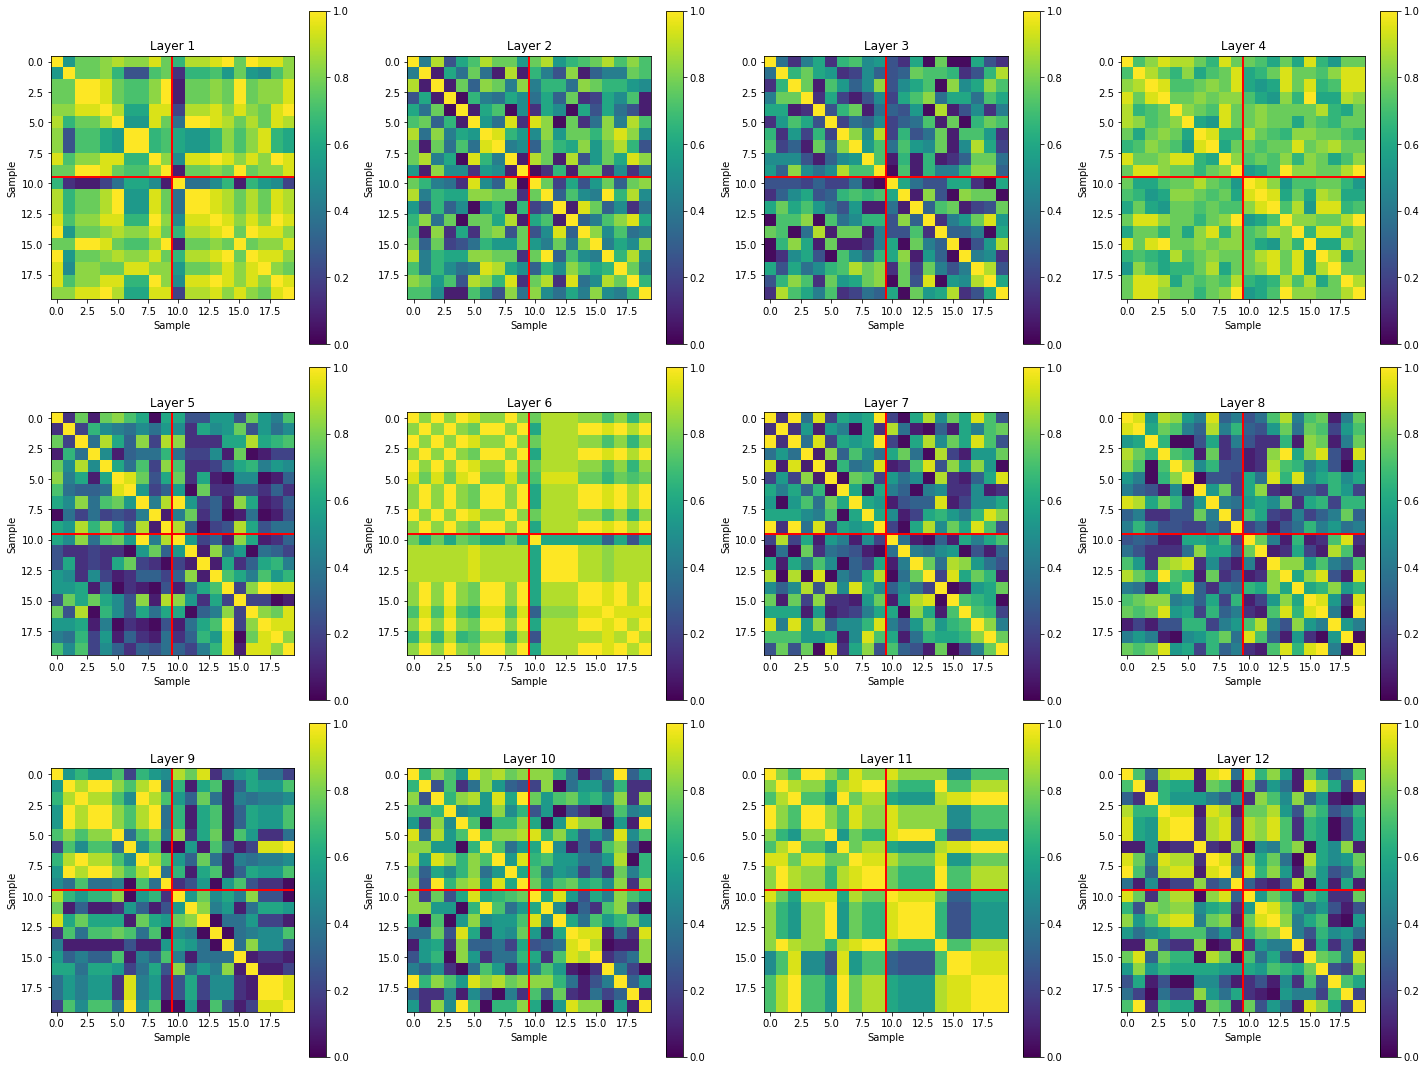

In [44]:
from scipy.stats import spearmanr
# 计算每一层的Spearman相关性矩阵
def calc_spearman_matrices(flattened_matrices, layers=12, samples=20):
    layer_matrices = []
    for layer in range(layers):
        spearman_matrix = np.zeros((samples, samples))
        for i in range(samples):
            for j in range(samples):
                matrix_i = flattened_matrices[i*layers + layer]
                matrix_j = flattened_matrices[j*layers + layer]
                rho, _ = spearmanr(matrix_i, matrix_j)
                spearman_matrix[i, j] = abs(rho)
        layer_matrices.append(spearman_matrix)
    return layer_matrices

# 计算每层的Spearman相关性矩阵
spearman_matrices = calc_spearman_matrices(flattened_matrices)

# 绘制这些矩阵
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
for i, ax in enumerate(axs.flat):
    im = ax.imshow(spearman_matrices[i], cmap='viridis', vmin=0, vmax=1)
    ax.set_title(f'Layer {i+1}')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Sample')
    plt.colorbar(im, ax=ax)
    ax.axhline(y = 9.5, color = 'r', linestyle = '-', linewidth = 2)
    ax.axvline(x = 9.5, color = 'r', linestyle = '-', linewidth = 2)
plt.tight_layout()
plt.show()

PCA探究组内是否聚集

0
1
2
3
4
5
6
7
8
9
10
11


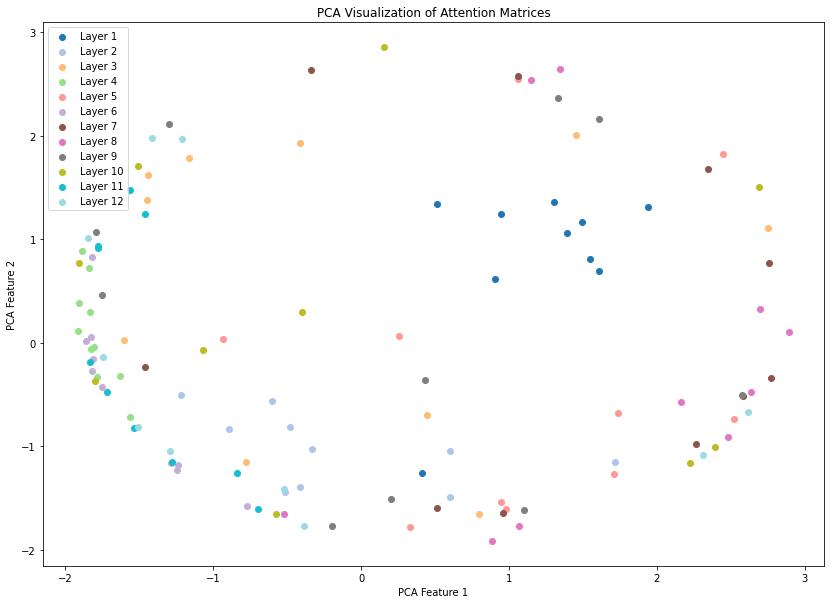

In [55]:
from sklearn.decomposition import PCA

# 假设 flattened_matrices 已经是你要处理的数据
# n_features 为拉平后的注意力矩阵的特征数

# 使用PCA进行降维
pca = PCA(n_components=2, random_state=0)
pca_results = pca.fit_transform(flattened_matrices)

# 可视化
plt.figure(figsize=(14, 10))
colors = plt.cm.tab20(np.linspace(0, 1, 12))  # 为12个层生成颜色
#layer_colors = np.array([colors[0]]*2 + [colors[1]]*1 + [colors[2]]*1 + [colors[3]]*1 + [colors[4]]*1 + [colors[5]]*1 + [colors[6]]*2+ [colors[7]]*1 + [colors[8]]*2)
#print(layer_colors)
for i, color in zip(range(12), colors):
    # 每个语料的每个层都有一个点，我们根据层来着色
    print(i)
    plt.scatter(pca_results[i::12, 0], pca_results[i::12, 1], color=color, label=f'Layer {i+1}')

plt.legend()
plt.title('PCA Visualization of Attention Matrices')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.show()


0
1
2
3
4
5
6
7
8
9
10
11


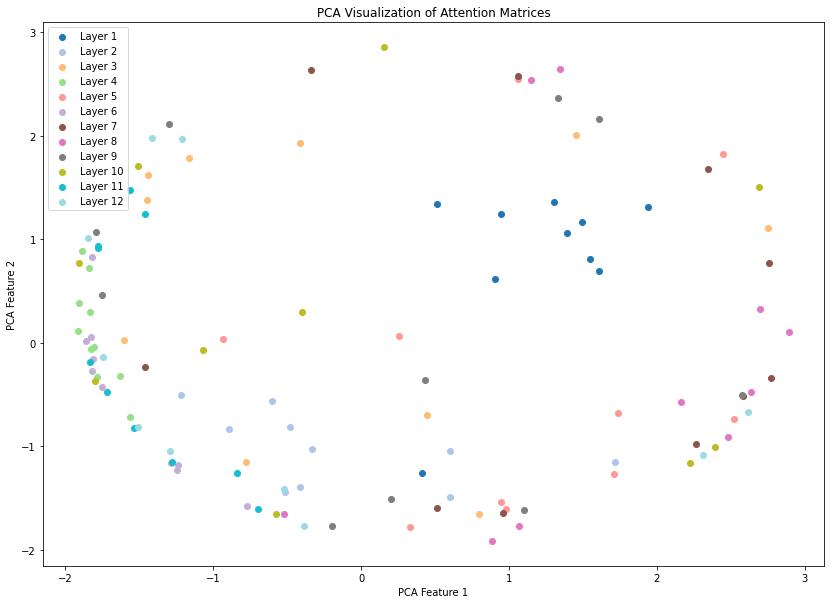

In [123]:
from sklearn.decomposition import PCA

# 假设 flattened_matrices 已经是你要处理的数据
# n_features 为拉平后的注意力矩阵的特征数

# 使用PCA进行降维
pca = PCA(n_components=2, random_state=0)
pca_results = pca.fit_transform(flattened_matrices)

# 可视化
plt.figure(figsize=(14, 10))
colors = plt.cm.tab20(np.linspace(0, 1, 12))  # 为12个层生成颜色
#layer_colors = np.array([colors[0]]*2 + [colors[1]]*1 + [colors[2]]*1 + [colors[3]]*1 + [colors[4]]*1 + [colors[5]]*1 + [colors[6]]*2+ [colors[7]]*1 + [colors[8]]*2)
#print(layer_colors)
for i, color in zip(range(12), colors):
    # 每个语料的每个层都有一个点，我们根据层来着色
    print(i)
    plt.scatter(pca_results[i::12, 0], pca_results[i::12, 1], color=color, label=f'Layer {i+1}')

plt.legend()
plt.title('PCA Visualization of Attention Matrices')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.show()


PCA探究组间是否可分

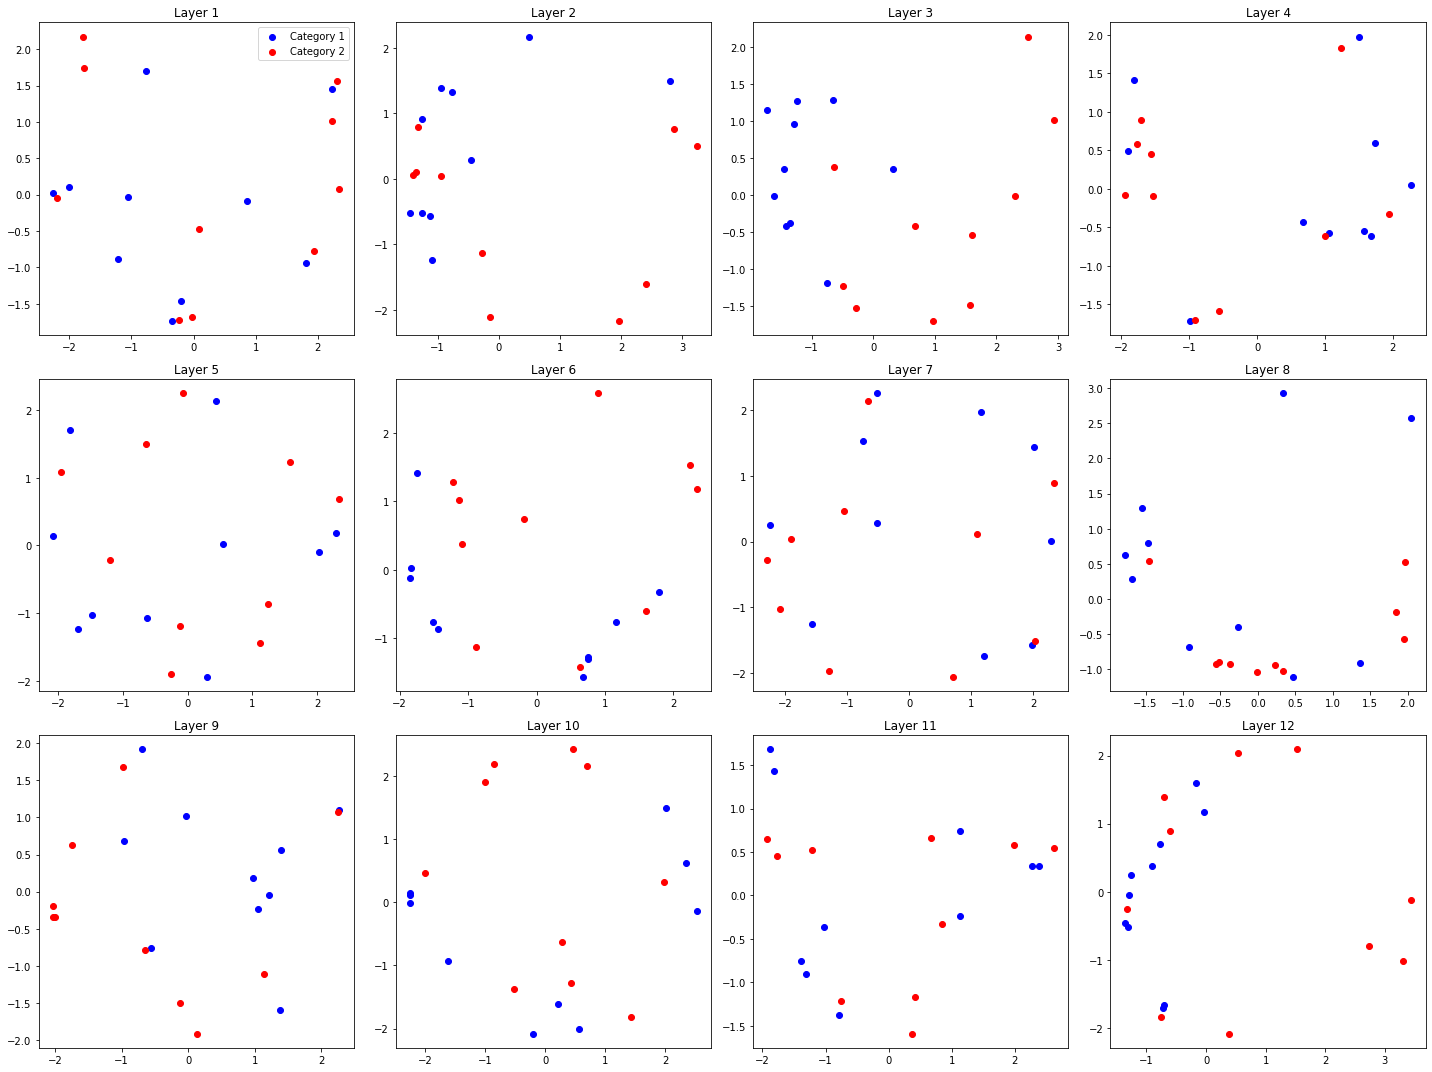

In [12]:
from sklearn.decomposition import PCA

# 假设 flattened_matrices 是你已经准备好的数据，形状为 (180, n_features)

n_layers = 12
n_samples_per_layer = 20
n_categories = 2  # 两种语料的类别

fig, axs = plt.subplots(3, 4, figsize=(20, 15))  # 准备一个3x4的子图网格来绘制每个层的t-SNE结果
axs = axs.flatten()  # 将子图数组拉平，方便索引

for i in range(n_layers):
    # 提取当前层的数据
    layer_data = flattened_matrices[i*n_samples_per_layer:(i+1)*n_samples_per_layer, :]
    
    # 应用t-SNE降维到2D，设置适当的perplexity值
    #tsne = TSNE(n_components=2, perplexity=min(10, n_samples_per_layer - 1), random_state=0)
    #tsne_results = tsne.fit_transform(layer_data)
    pca = PCA(n_components=2, random_state=0)
    pca_results = pca.fit_transform(layer_data)
    
    ax = axs[i]
    # 前10个语料一种颜色，后5个语料另一种颜色
    ax.scatter(pca_results[:10, 0], pca_results[:10, 1], color='blue', label='Category 1')
    ax.scatter(pca_results[10:, 0], pca_results[10:, 1], color='red', label='Category 2')
    
    ax.set_title(f'Layer {i+1}')
    if i == 0:  # 只在第一个子图中显示图例
        ax.legend()

plt.tight_layout()
plt.show()



TypeError: 'AxesSubplot' object is not subscriptable

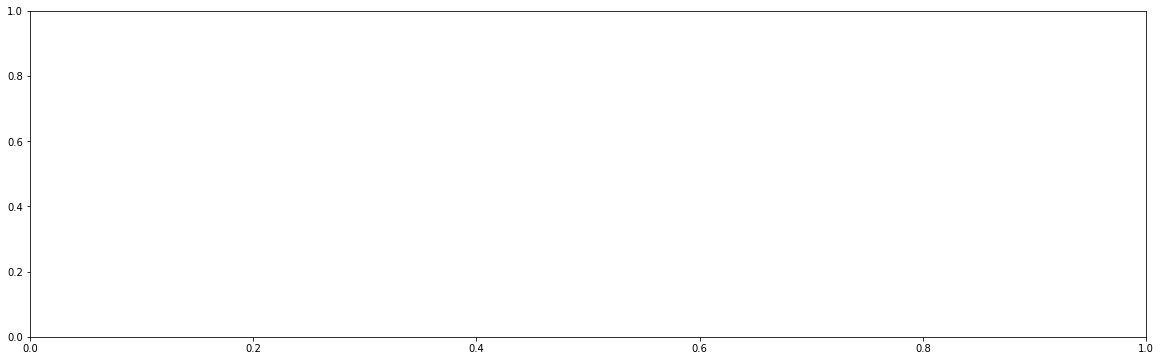

In [129]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# 假设 flattened_matrices 是你已经准备好的数据，形状为 (180, n_features)

n_groups = 1  # 将12个层分成3组，每组4个层
n_samples_per_group = n_samples_per_layer * 12  # 每组的样本数

fig, axs = plt.subplots(1, 1, figsize=(20, 6))  # 准备一个1x3的子图网格

for i in range(n_groups):
    # 提取当前组的数据
    group_data = flattened_matrices[i*n_samples_per_group:(i+1)*n_samples_per_group, :]
    
    # 应用t-SNE降维到2D，设置适当的perplexity值
    #tsne = TSNE(n_components=2, perplexity=min(30, n_samples_per_group // 4), random_state=0)
    #tsne_results = tsne.fit_transform(group_data)
    pca = PCA(n_components=2, random_state=0)
    pca_results = pca.fit_transform(group_data)
    
    ax = axs[i]
    # 每组内前40个语料一种颜色，后20个语料另一种颜色（因为每组有4个层）
    ax.scatter(pca_results[:120, 0], pca_results[:120, 1], color='blue', label='Category 1')
    ax.scatter(pca_results[120:, 0], pca_results[120:, 1], color='red', label='Category 2')
    
    ax.set_title(f'Group {i+1}')
    if i == 0:  # 只在第一个子图中显示图例
        ax.legend()

plt.tight_layout()
plt.show()


1.2 尝试构建Avg Attention情况

In [21]:
# 设置matplotlib字体以支持中文
#matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 或者您可以使用其他支持中文的字体
#matplotlib.rcParams['font.family'] = 'sans-serif'

# 初始化分词器和模型
tokenizer = BertTokenizer.from_pretrained('F:/project/Attention/bert-base-chinese')
model = BertModel.from_pretrained('F:/project/Attention/bert-base-chinese', output_attentions=True).eval()

# 读取语料
with open("F:/project/Attention/corpus2.txt", "r", encoding="utf-8") as file:
    corpus = [line.strip() for line in file.readlines()]
  

# 准备画布
fig, axs = plt.subplots(len(corpus), 12, figsize=(30, 20), sharex='col', sharey='row',
                        gridspec_kw={'wspace':0.5, 'hspace':0.2, 'right':0.85})

# 累积所有子图的attention矩阵，用于确定colorbar的范围
all_attentions = []

for corpus_index, text in enumerate(corpus):
    sentences = text.split('。')[:-1]
    input_text = "[CLS] " + "[SEP] [CLS] ".join(sentences) + "[SEP]"

    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)

    input_ids = inputs['input_ids']
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    cls_positions = [pos for pos, token in enumerate(tokens) if token == "[CLS]"]
    
    num_sentences = len(cls_positions) - 1


    for layer in range(12):
        all_heads_attention = outputs.attentions[layer][0].mean(dim=0)
        sentence_attention = torch.zeros((num_sentences, num_sentences))

        for i in range(num_sentences):
            start_from = cls_positions[i+1]
            end_from = cls_positions[i+2] if i+2 < len(cls_positions) else len(tokens)

            for j in range(num_sentences):
                start_to = cls_positions[j+1]
                end_to = cls_positions[j+2] if j+2 < len(cls_positions) else len(tokens)

                sentence_attention[i, j] = torch.mean(all_heads_attention[start_from:end_from, start_to:end_to])

        
        # 计算平均值和标准差
        #mean = torch.mean(sentence_attention, dim=-1, keepdim=True)
        #std = torch.std(sentence_attention, dim=-1, keepdim=True)
        #mean = torch.mean(sentence_attention)
        #std = torch.std(sentence_attention)

        # 进行Z-score归一化
        #sentence_attention_normalized = (sentence_attention - mean) / std
        
        all_attentions.append(sentence_attention)
        
        ax = axs[corpus_index, layer]
        im = ax.matshow(sentence_attention.detach().numpy(), cmap='viridis')
        if layer == 0:
            ax.set_yticks(range(num_sentences))
        if corpus_index == 0:
            ax.set_title(f'Layer {layer+1}')

# 创建一个大colorbar适用于所有子图
cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])  # 适当调整colorbar的位置和大小
fig.colorbar(im, cax=cbar_ax)

#plt.savefig('all_attention_visualization.png')  # 保存图像
plt.close(fig)  # 如果不需要在Jupyter等环境中显示，可以关闭图形以节省资源


Stopwords 情况

In [ ]:
cn_stopwords_path = 'F:/project/Attention/cn_stopwords.txt'  # 停词文件的路径
with open(cn_stopwords_path, 'r', encoding='utf-8') as f:
    cn_stopwords = {line.strip() for line in f.readlines()}

# 初始化分词器和模型
tokenizer = BertTokenizer.from_pretrained('F:/project/Attention/bert-base-chinese')
model = BertModel.from_pretrained('F:/project/Attention/bert-base-chinese', output_attentions=True).eval()

# 读取语料
with open("F:/project/Attention/corpus.txt", "r", encoding="utf-8") as file:
    corpus = [line.strip() for line in file.readlines()]
  

# 准备画布
fig, axs = plt.subplots(len(corpus), 12, figsize=(30, 20), sharex='col', sharey='row',
                        gridspec_kw={'wspace':0.5, 'hspace':0.2, 'right':0.85})

# 累积所有子图的attention矩阵，用于确定colorbar的范围
all_attentions = []

for corpus_index, text in enumerate(corpus):
    sentences = text.split('。')[:-1]
    input_text = "[CLS] " + "[SEP] [CLS] ".join(sentences) + "[SEP]"

    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)

    input_ids = inputs['input_ids']
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    cls_positions = [pos for pos, token in enumerate(tokens) if token == "[CLS]"]
    
    num_sentences = len(cls_positions) - 1

    for layer in range(12):
        all_heads_attention = outputs.attentions[layer][0].mean(dim=0)
        sentence_attention = torch.zeros((num_sentences, num_sentences))

        for i in range(num_sentences):
            start_from = cls_positions[i+1]
            end_from = cls_positions[i+2] if i+2 < len(cls_positions) else len(tokens)

            for j in range(num_sentences):
                start_to = cls_positions[j+1]
                end_to = cls_positions[j+2] if j+2 < len(cls_positions) else len(tokens)

                # 过滤停用词
                valid_attention_values = []
                for k in range(start_from, end_from):
                    if tokens[k] not in cn_stopwords:
                        for l in range(start_to, end_to):
                            if tokens[l] not in cn_stopwords:
                                print(tokens[l])
                                valid_attention_values.append(all_heads_attention[k, l])

                if valid_attention_values:
                    sentence_attention[i, j] = torch.tensor(valid_attention_values).mean()
                else:
                    sentence_attention[i, j] = torch.tensor(0.0)  # 如果没有有效attention值，可选择适当的默认值

        all_attentions.append(sentence_attention)
        
        ax = axs[corpus_index, layer]
        im = ax.matshow(sentence_attention.detach().numpy(), cmap='viridis')
        if layer == 0:
            ax.set_yticks(range(num_sentences))
        if corpus_index == 0:
            ax.set_title(f'Layer {layer+1}')

# 创建一个大colorbar适用于所有子图
cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])  # 适当调整colorbar的位置和大小
fig.colorbar(im, cax=cbar_ax)

#plt.savefig('all_attention_visualization.png')  # 保存图像
plt.close(fig)  # 如果不需要在Jupyter等环境中显示，可以关闭图形以节省资源



In [25]:
def transform_matrix(matrix):
    tril_indices = np.tril_indices_from(matrix, k=-1)
    transformed_matrix = np.full(matrix.shape, np.nan)  # 创建一个填充了NaN的矩阵
    transformed_matrix[tril_indices] = matrix[tril_indices]  # 只填充对角线和下三角
    return transformed_matrix

cut_matrices = []

for matrix in all_attentions:
    # 将每个矩阵拉平
    matrix = matrix.detach().numpy()
    cut_matrix = transform_matrix(matrix)
    cut_matrices.append(cut_matrix)

print(cut_matrices[0])


flattened_matrices = []

for matrix in cut_matrices:
    # 将每个矩阵拉平
    flattened_matrix = matrix.flatten()
    valid_indices = ~np.isnan(flattened_matrix) 
    mean = np.mean(flattened_matrix[valid_indices])
    std = np.std(flattened_matrix[valid_indices])
    final = (flattened_matrix[valid_indices] - mean) / std
    flattened_matrices.append(final)

# 将列表转换为numpy数组
flattened_matrices = np.array(flattened_matrices)

# 现在 flattened_matrices 是形状为 (120, n_features) 的数组
# 其中 n_samples 为 120 (10个语料 * 12个层)

[[       nan        nan        nan        nan]
 [0.00643211        nan        nan        nan]
 [0.00312165 0.00512171        nan        nan]
 [0.00226849 0.00318497 0.00600099        nan]]


In [26]:
from scipy.stats import zscore
# Z-score标准化每个矩阵的上三角数值
for matrix in cut_matrices:
    upper_triangle_indices = np.tril_indices(4, k=-1)
    matrix[upper_triangle_indices] = zscore(1-(matrix[upper_triangle_indices][~np.isnan(matrix[upper_triangle_indices])]))

In [5]:
print(layers_matrices[12][0])
print(cut_matrices[11])

plt.imshow(cut_matrices[11], cmap = "magma", vmin = -2, vmax = 2)
plt.xticks(range(4), ['Sen 1', 'Sen 2', 'Sen 3', 'Sen 4'])
plt.yticks(range(4), ['Sen 1', 'Sen 2', 'Sen 3', 'Sen 4'])
plt.title('Output Example')
plt.colorbar()

NameError: name 'layers_matrices' is not defined

In [6]:
# 从cut_matrices中提取属于第7层到第12层的样本矩阵
sample_matrices = {sample: [] for sample in range(1,21)}
for i, matrix in enumerate(cut_matrices):
    layer = i % 12 + 1  # 确定当前矩阵属于哪一层
    sample = i//12 + 1 
    if 10 <= layer <= 12:
        sample_matrices[sample].append(matrix)

mean_group = []
for i in range(1,21):
    sample_group = sample_matrices[i]
    whole = np.array(sample_group)
    mean_matrix = np.nanmean(whole, axis = 0)
    mean_group.append(mean_matrix)

print(mean_group[0])

from scipy.stats import zscore
# Z-score标准化每个矩阵的上三角数值
for matrix in mean_group:
    upper_triangle_indices = np.tril_indices(4, k=-1)
    matrix[upper_triangle_indices] = zscore(1-(matrix[upper_triangle_indices][~np.isnan(matrix[upper_triangle_indices])]))

print(mean_group[0])

[[        nan         nan         nan         nan]
 [-1.22296935         nan         nan         nan]
 [-0.55763736  1.02944143         nan         nan]
 [-0.38911591  1.63883367 -0.49855248         nan]]
[[        nan         nan         nan         nan]
 [ 1.22787998         nan         nan         nan]
 [ 0.55987646 -1.03357498         nan         nan]
 [ 0.39067834 -1.64541413  0.50055434         nan]]


C:\Users\admin\AppData\Local\Temp\ipykernel_26720\1282581573.py:13: RuntimeWarning: Mean of empty slice
  mean_matrix = np.nanmean(whole, axis = 0)


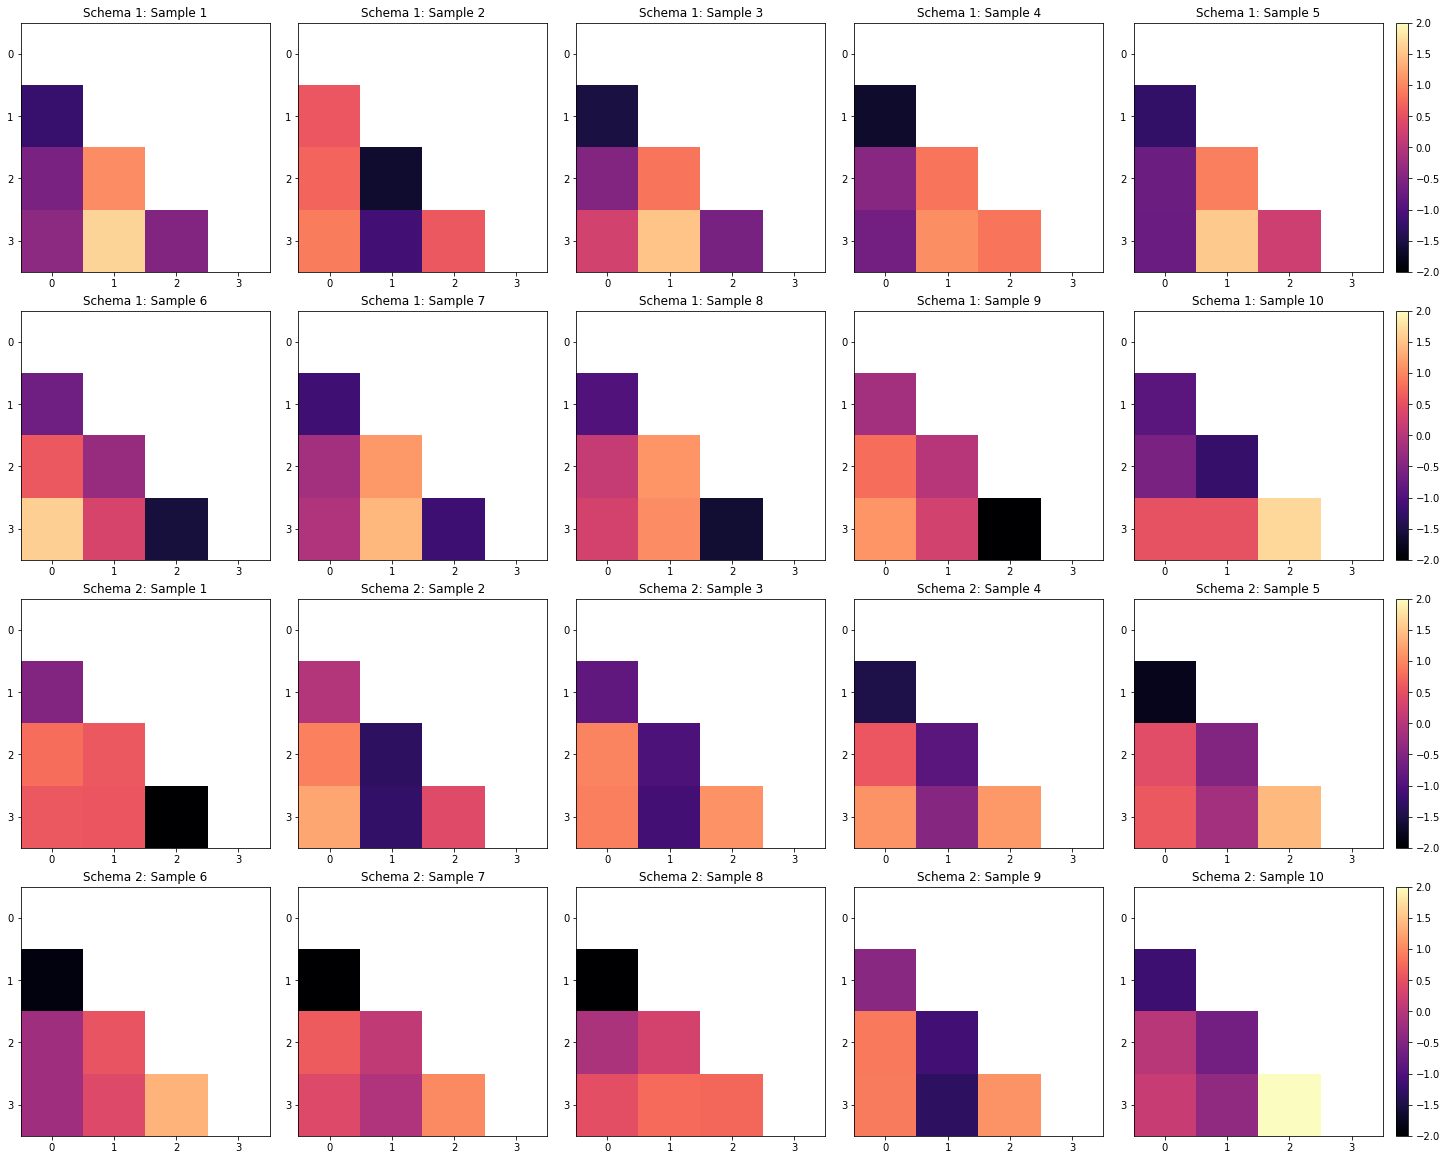

In [117]:
fig, axs = plt.subplots(4, 5, figsize=(20, 16), constrained_layout=True)

# 分别可视化20个样本矩阵
for i, ax in enumerate(axs.flat):
    matrix = mean_group[i]
    im = ax.imshow(matrix, cmap='magma', vmin=-2, vmax=2)
    if i < 10:
        ax.set_title(f'Schema 1: Sample {i+1}')
    else: 
        ax.set_title(f'Schema 2: Sample {i-9}')
    ax.set_xticks(range(4))
    ax.set_yticks(range(4))
    
# 为每排的最后一个图添加统一范围的colorbar
for i in range(4):
    fig.colorbar(im, ax=axs[i, -1])

plt.show()


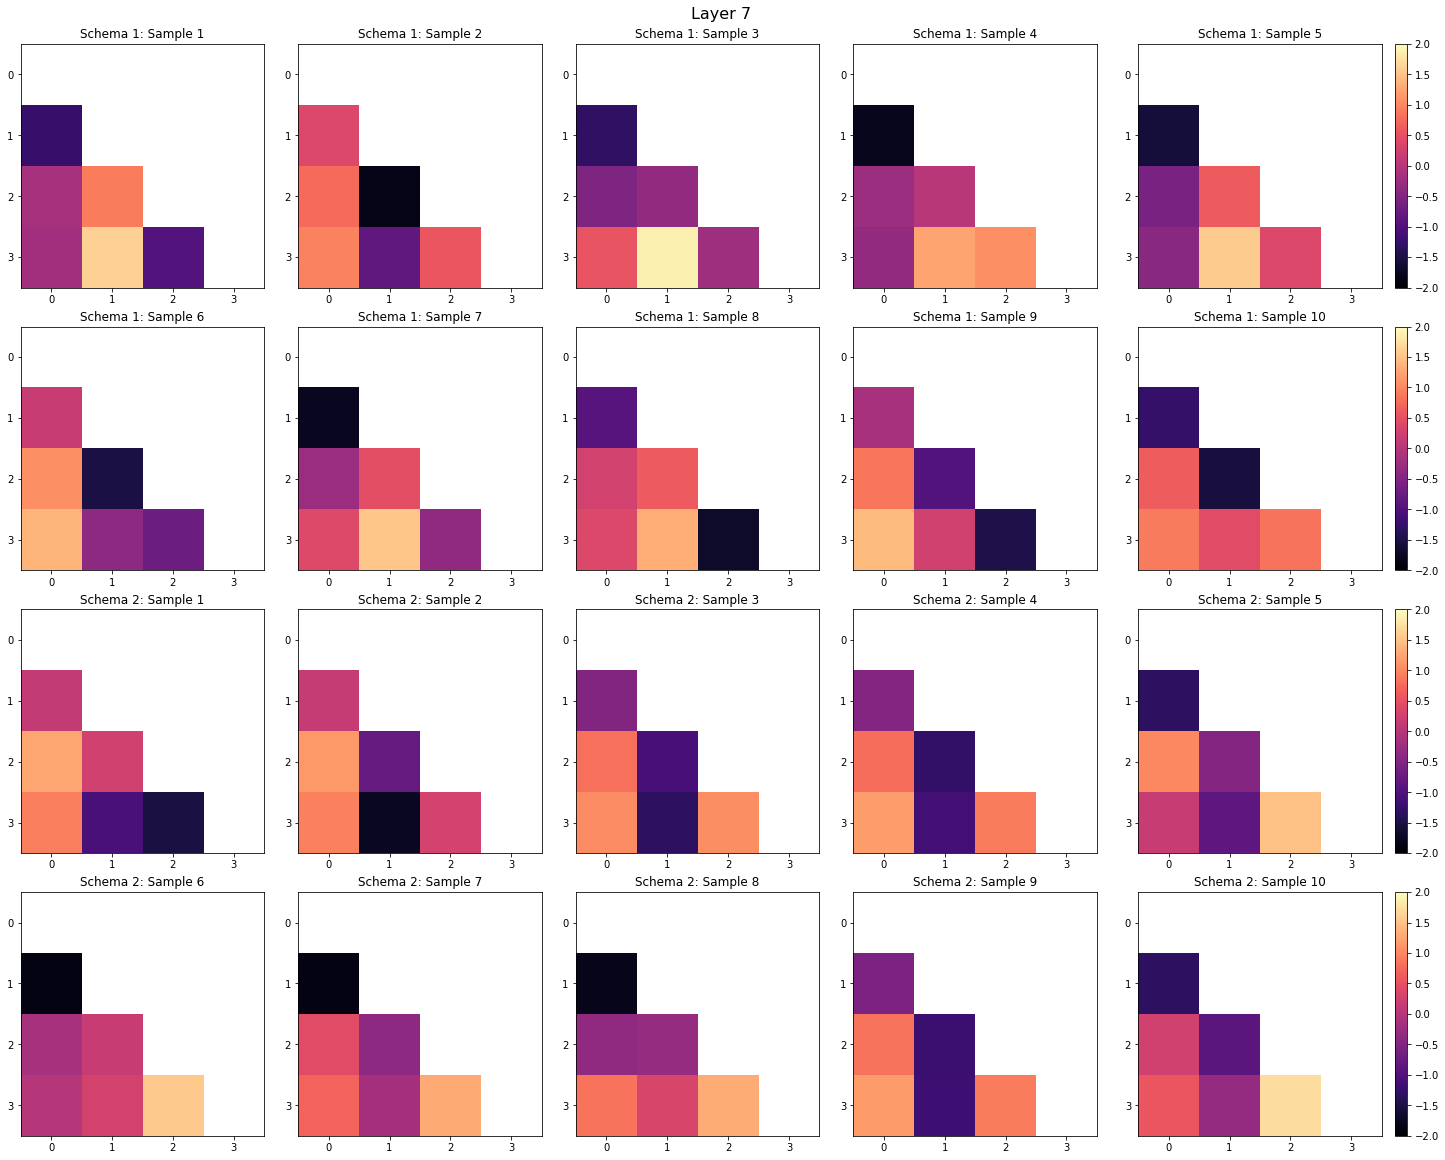

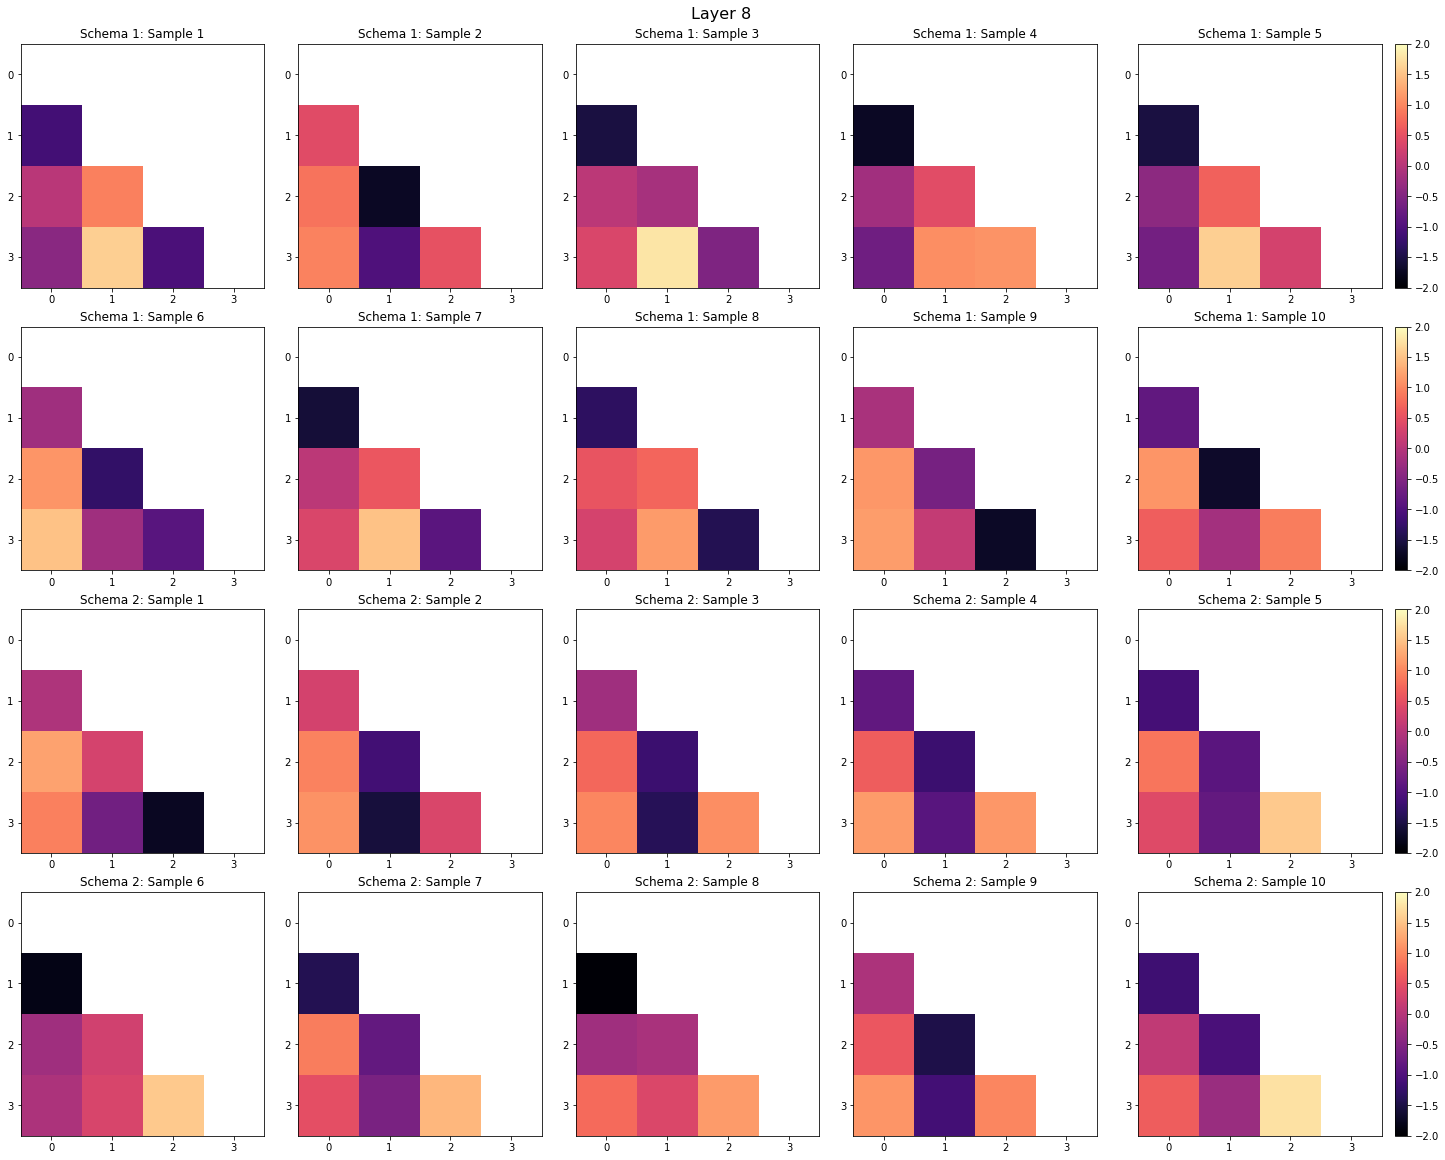

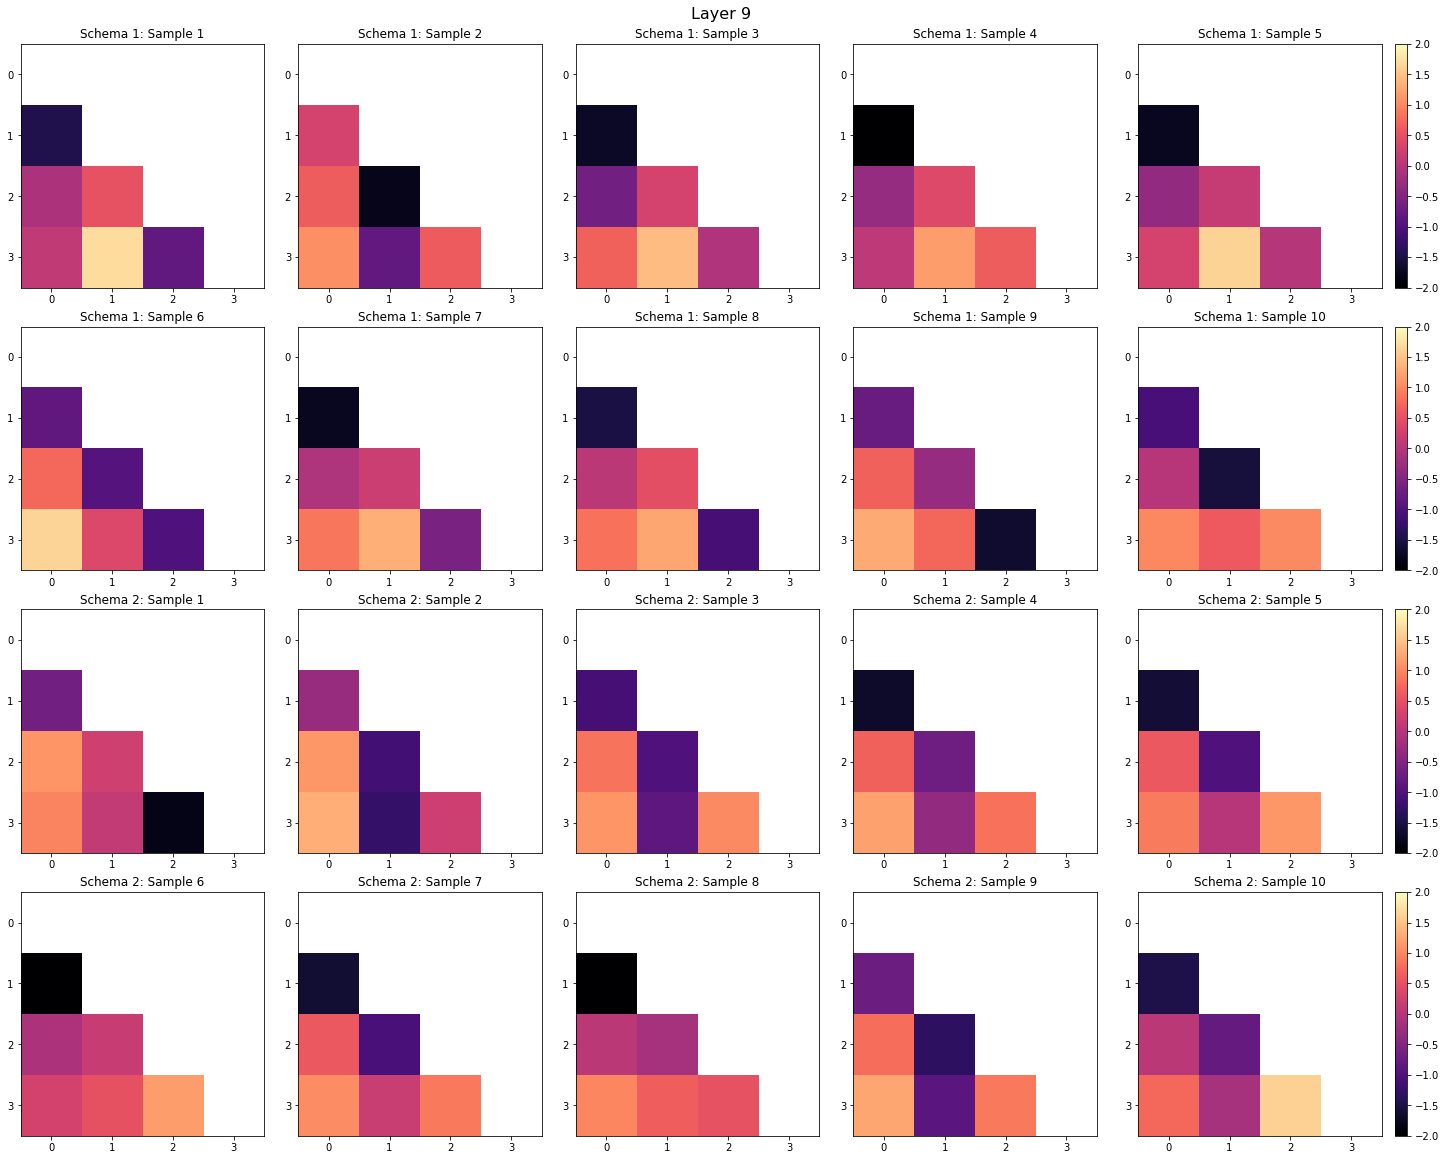

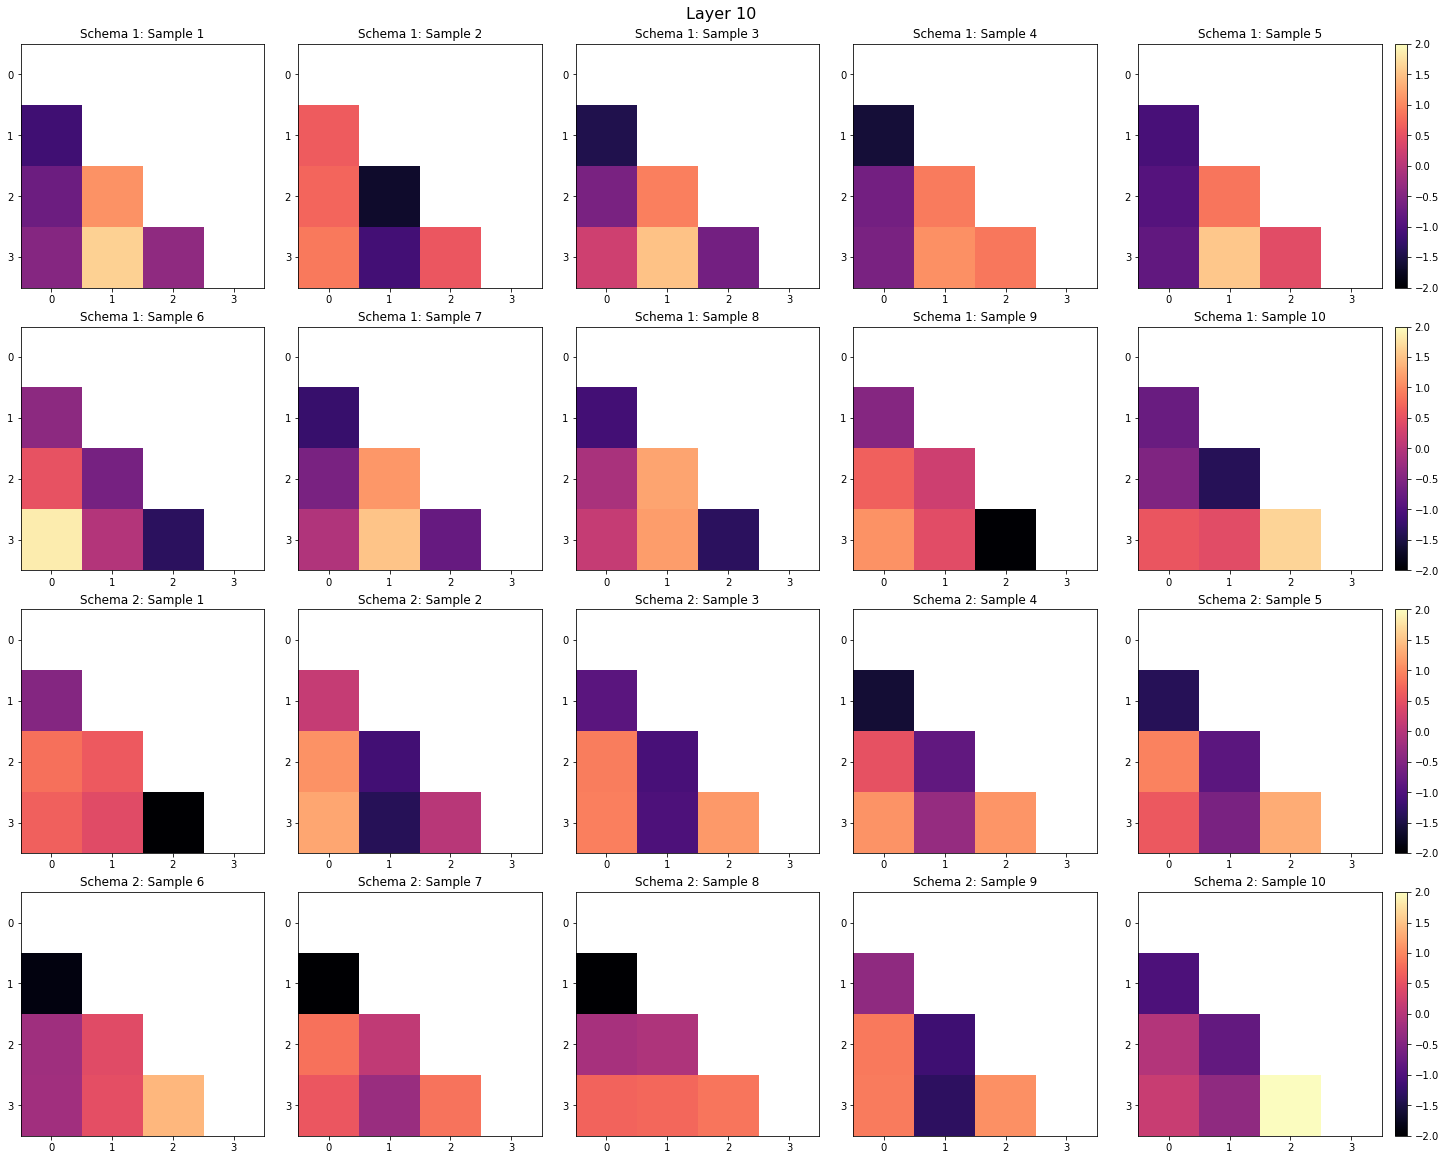

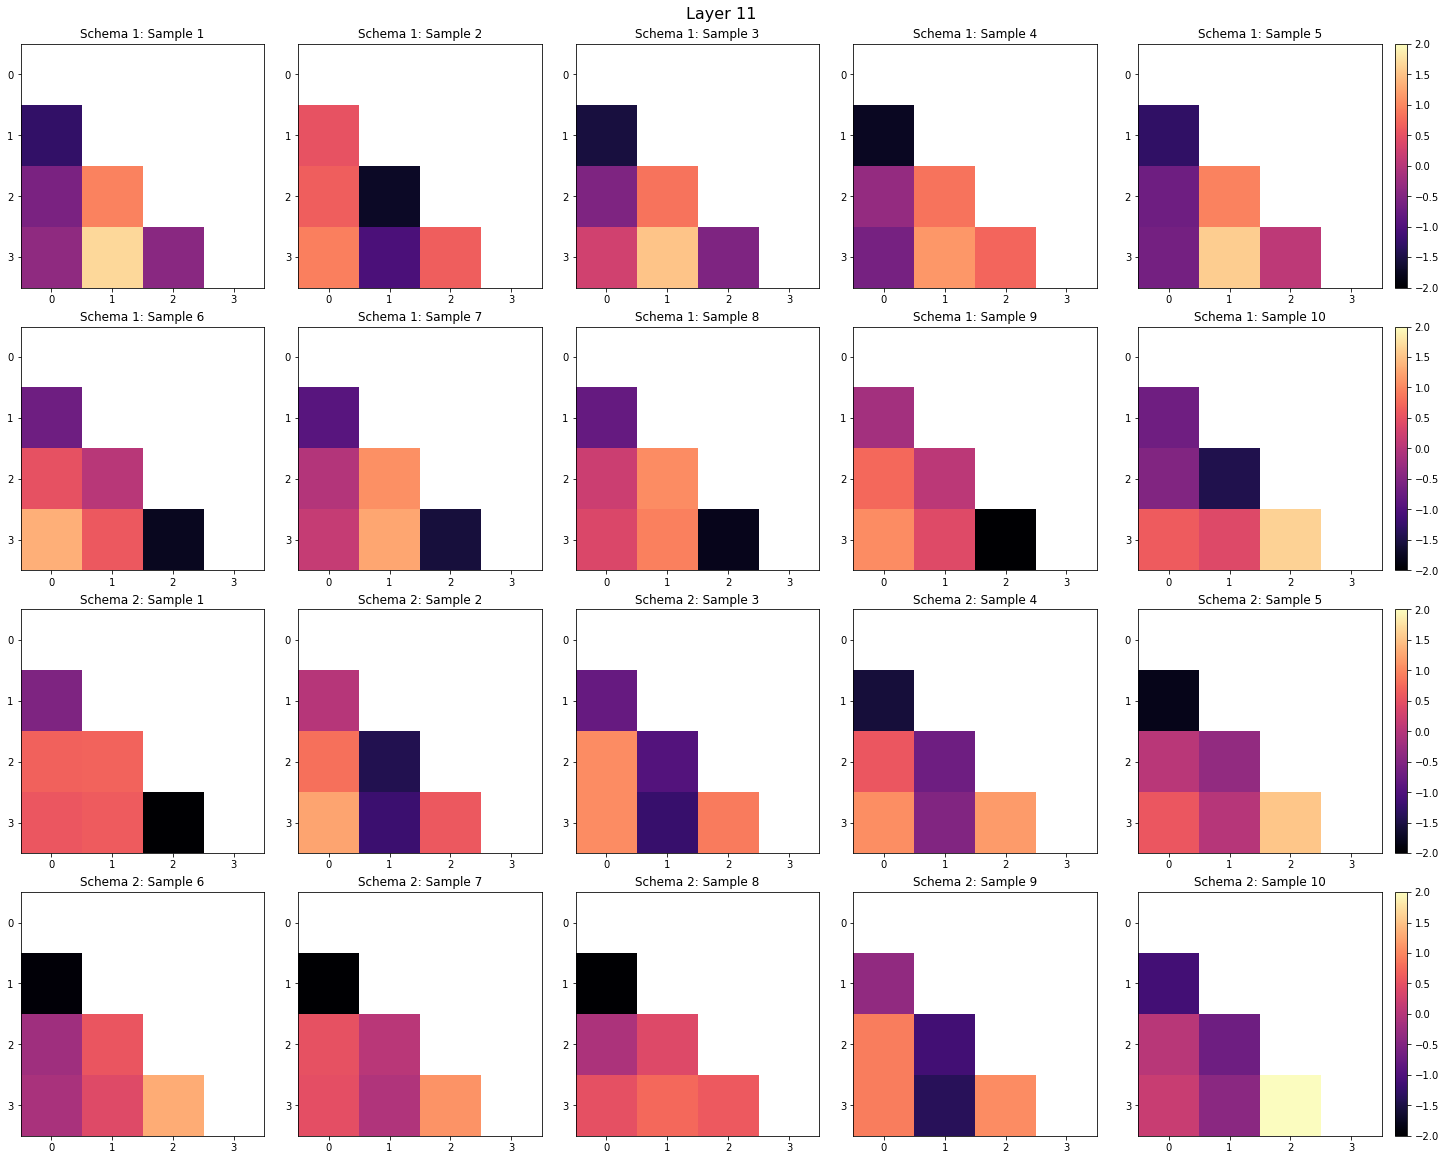

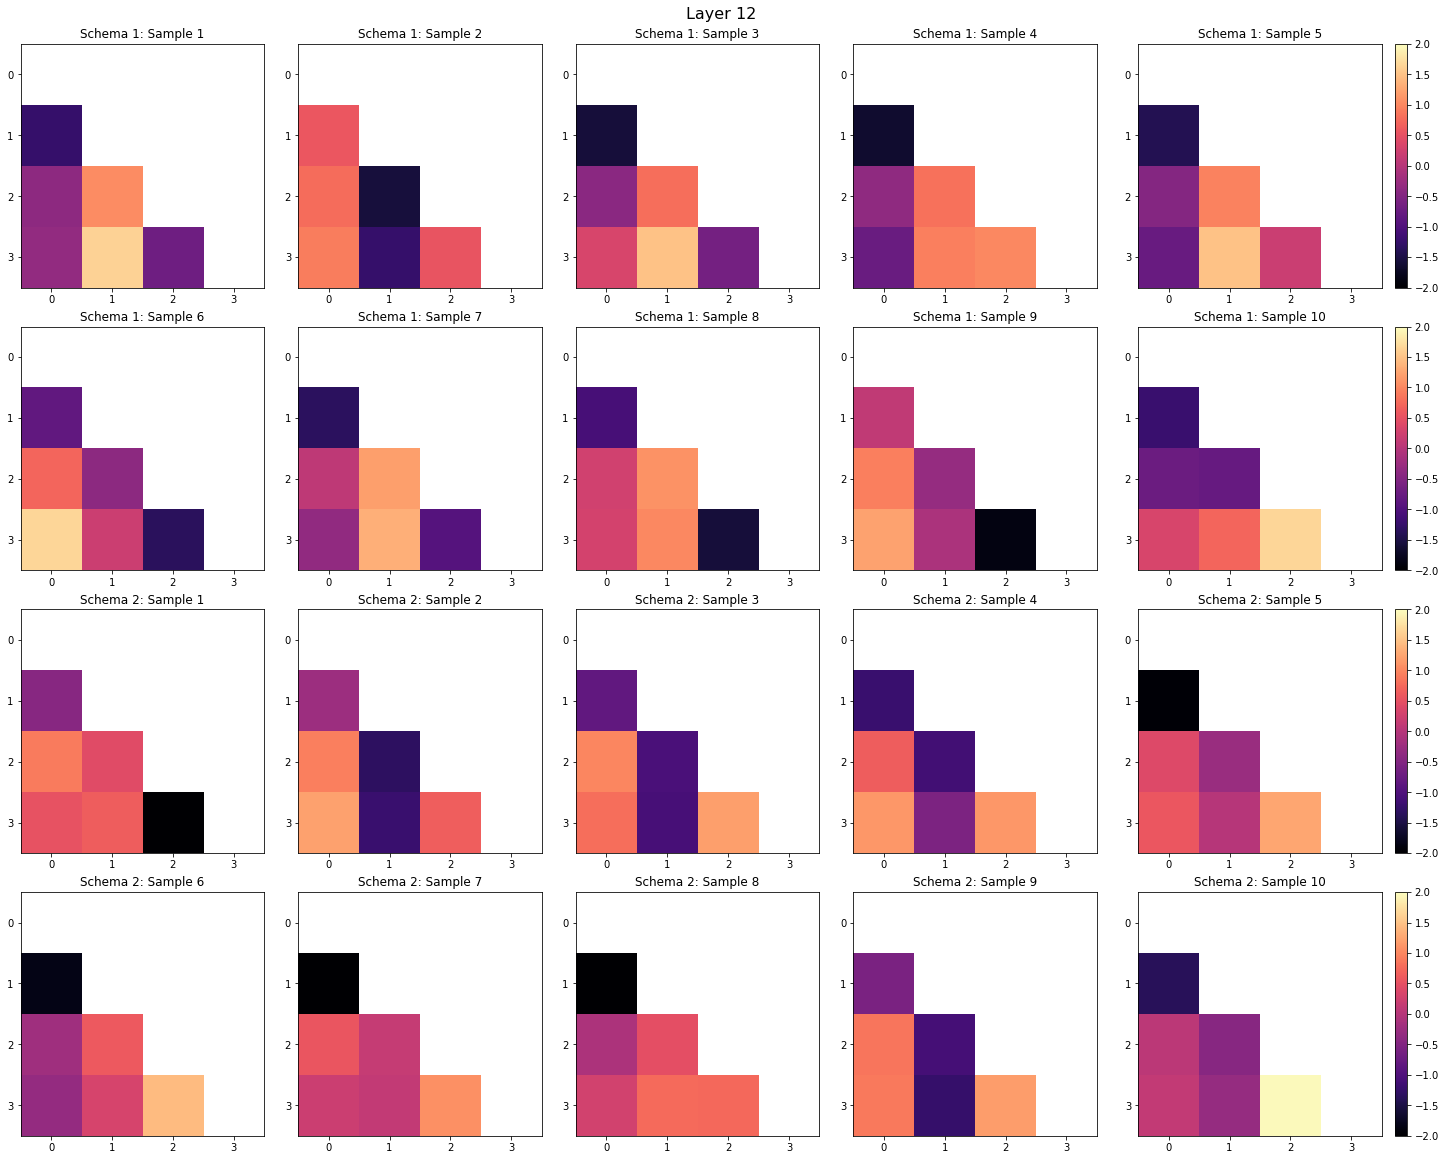

In [7]:

# 从cut_matrices中提取属于第7层到第12层的样本矩阵
layers_matrices = {layer: [] for layer in range(7, 13)}
for i, matrix in enumerate(cut_matrices):
    layer = i % 12 + 1  # 确定当前矩阵属于哪一层
    if 7 <= layer <= 12:
        layers_matrices[layer].append(matrix)

# 对于第7层到第12层，每层分别可视化20个样本矩阵
for layer, matrices in layers_matrices.items():
    # 确定这一层的Z-score值的全局最小和最大值
    zscore_min, zscore_max = np.nan, np.nan
    for matrix in matrices:
        current_min = np.nanmin(matrix)
        current_max = np.nanmax(matrix)
        zscore_min = current_min if np.isnan(zscore_min) else min(zscore_min, current_min)
        zscore_max = current_max if np.isnan(zscore_max) else max(zscore_max, current_max)
    
    # 可视化
    fig, axs = plt.subplots(4, 5, figsize=(20, 16), constrained_layout=True)
    fig.suptitle(f'Layer {layer}', fontsize=16)

    for i, ax in enumerate(axs.flat):
        im = ax.imshow(matrices[i], cmap='magma', vmin=-2, vmax=2)
        if i < 10:
            ax.set_title(f'Schema 1: Sample {i+1}')
        else: 
            ax.set_title(f'Schema 2: Sample {i-9}')
        ax.set_xticks(range(4))
        ax.set_yticks(range(4))
    
    # 为每排的最后一个图添加统一范围的colorbar
    for i in range(4):
        fig.colorbar(im, ax=axs[i, -1])

    plt.show()



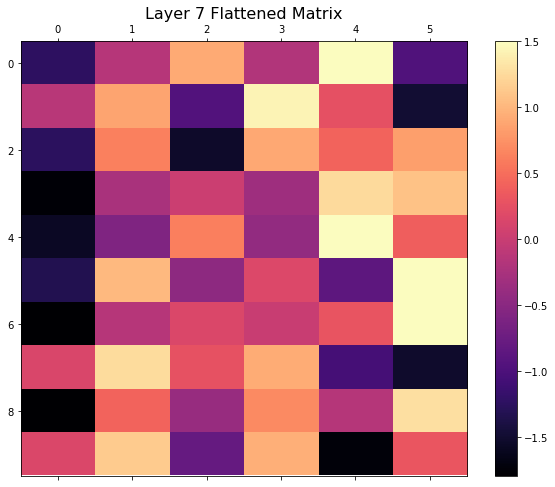

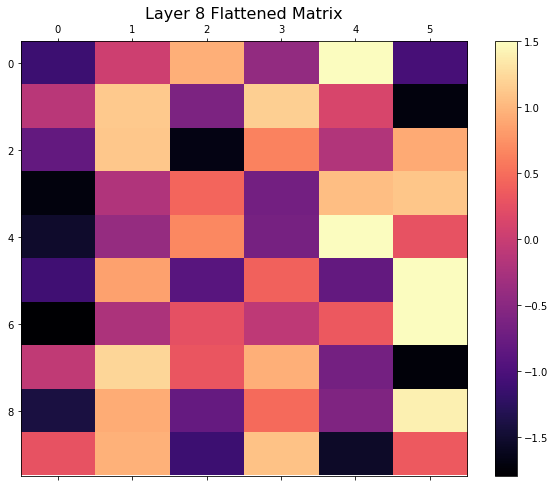

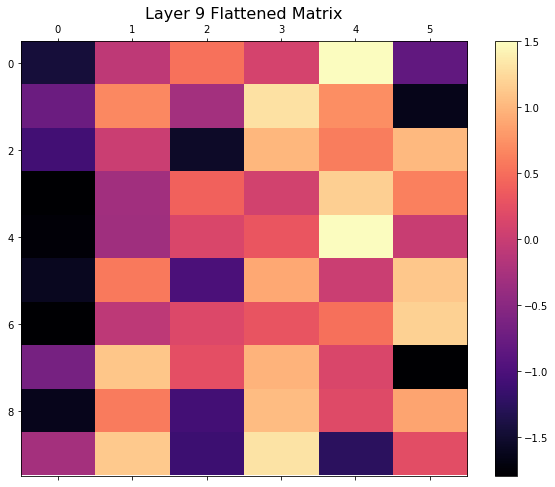

emb matrices saved to F:/project/Attention/fMRI_process/Dataset/MyData/gpt2-attention.txt


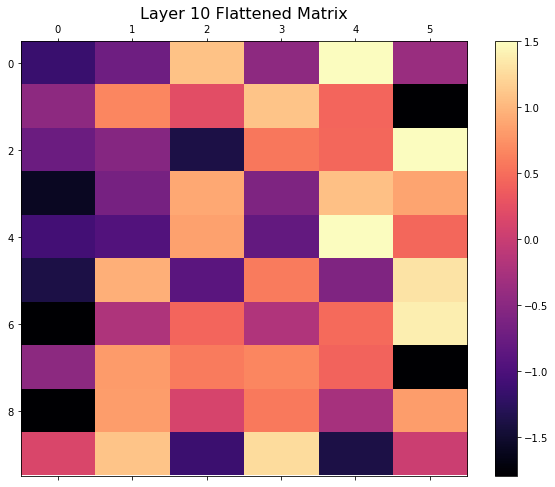

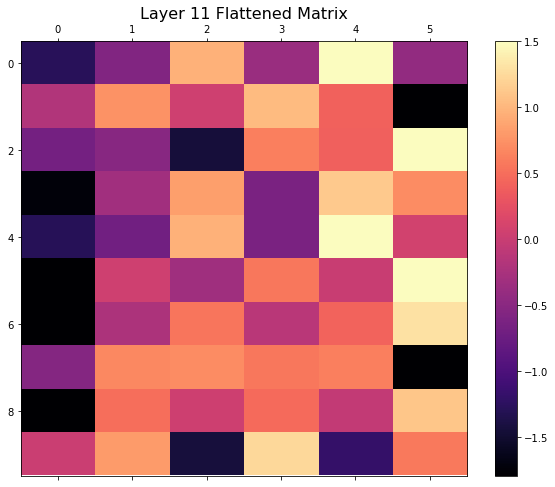

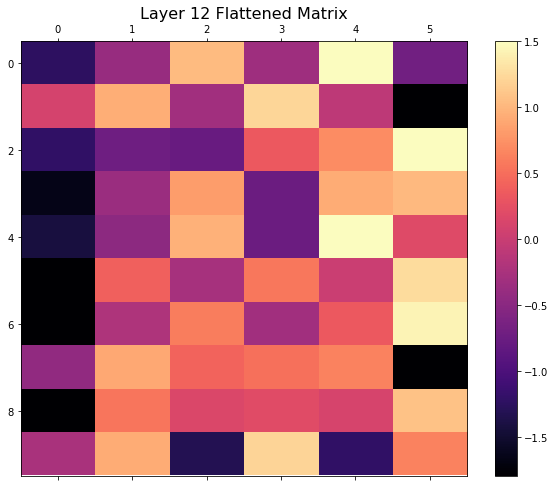

In [29]:

# 从cut_matrices中提取属于第7层到第12层的样本矩阵
layers_matrices = {layer: [] for layer in range(7, 13)}
for i, matrix in enumerate(cut_matrices):
    layer = i % 12 + 1  # 确定当前矩阵属于哪一层
    if 7 <= layer <= 12:
        layers_matrices[layer].append(matrix)

# 对于第7层到第12层，每层分别可视化20个样本矩阵
for layer, matrices in layers_matrices.items():
    # 创建一个新的大矩阵，每行代表原始矩阵的下三角拉平部分
    flat_matrices = []
    for matrix in matrices:
        # 提取下三角部分并拉平
        flat_matrix = matrix[np.tril_indices_from(matrix, k=-1)]
        flat_matrices.append(flat_matrix)

    # 将所有行堆叠成一个大矩阵
    stacked_matrix = np.vstack(flat_matrices)

    if layer == 10:
        save_path = 'F:/project/Attention/fMRI_process/Dataset/MyData/gpt2-attention.txt'
        # 确保只保存前20个矩阵，如果数量不足20个，则保存实际数量
        np.savetxt(save_path, stacked_matrix[:20], fmt='%f')  # fmt='%f' 指定保存为浮点数格式
        print(f'emb matrices saved to {save_path}')

    # 可视化大矩阵
    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.matshow(stacked_matrix, cmap='magma', aspect='auto', vmin = -1.8, vmax = 1.5)
    ax.axhline(y = 9.5, color = 'w', linestyle = '-', linewidth = 2)
    ax.set_title(f'Layer {layer} Flattened Matrix', fontsize=16)
    fig.colorbar(cax)

    plt.show()


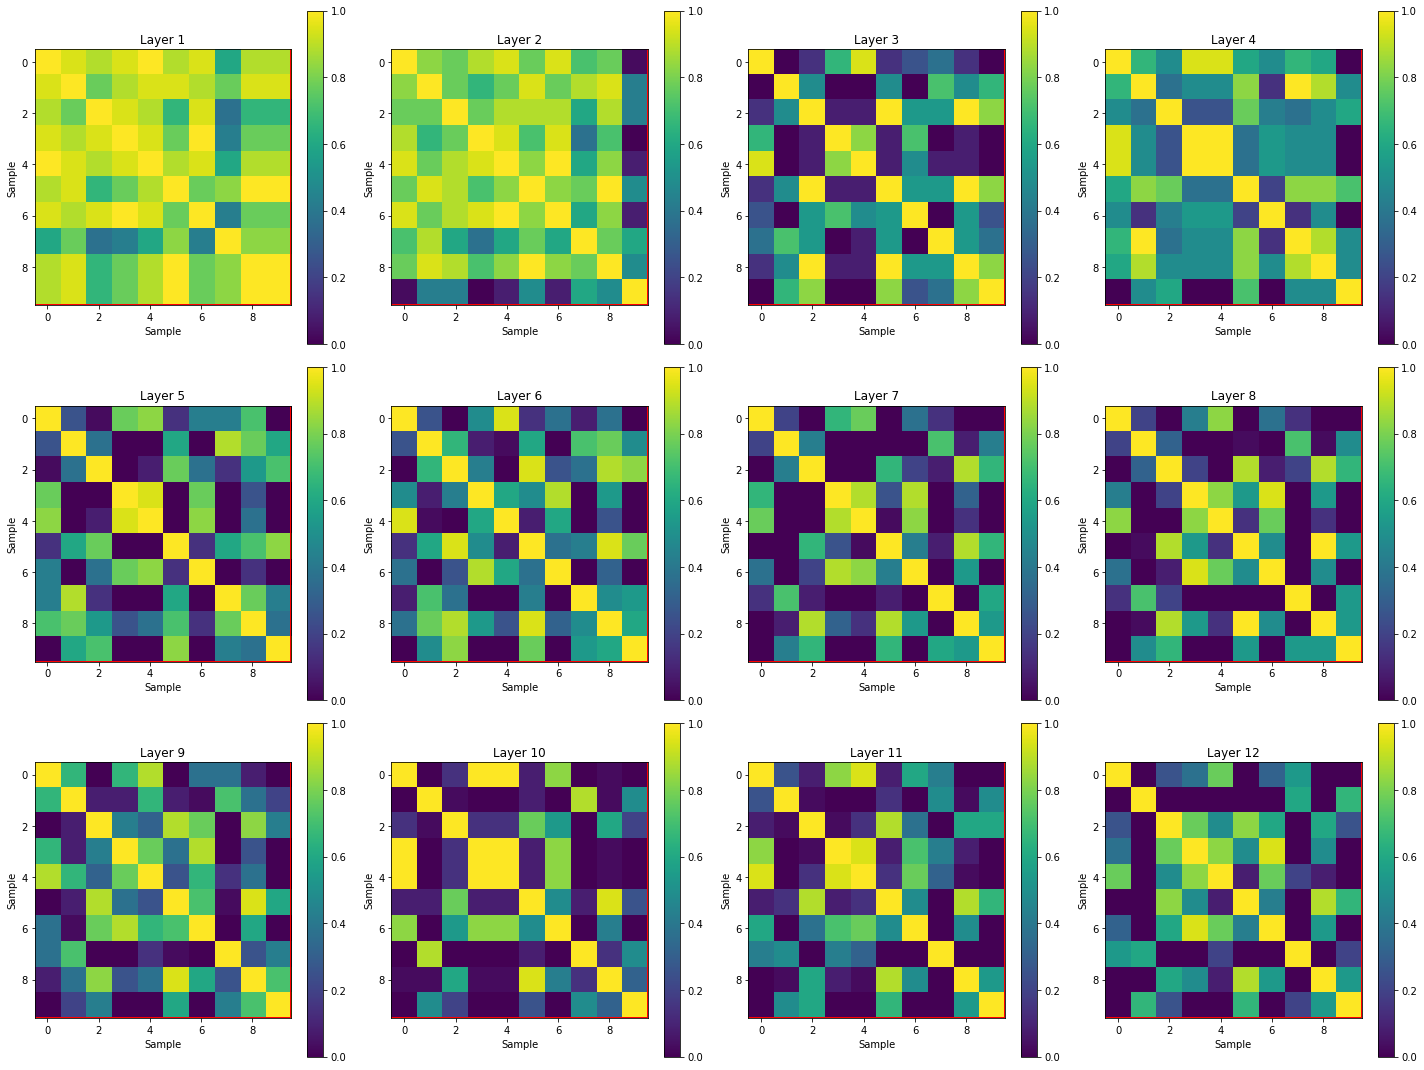

In [28]:
from scipy.stats import spearmanr
# 计算每一层的Spearman相关性矩阵
def calc_spearman_matrices(flattened_matrices, layers=12, samples=10):
    layer_matrices = []
    for layer in range(layers):
        spearman_matrix = np.zeros((samples, samples))
        for i in range(samples):
            for j in range(samples):
                matrix_i = flattened_matrices[i*layers + layer]
                matrix_j = flattened_matrices[j*layers + layer]
                rho, _ = spearmanr(matrix_i, matrix_j)
                spearman_matrix[i, j] = rho
        layer_matrices.append(spearman_matrix)
    return layer_matrices

# 计算每层的Spearman相关性矩阵
spearman_matrices = calc_spearman_matrices(flattened_matrices)

# 绘制这些矩阵
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
for i, ax in enumerate(axs.flat):
    im = ax.imshow(spearman_matrices[i], cmap = "viridis", vmin=0, vmax=1)
    ax.set_title(f'Layer {i+1}')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Sample')
    plt.colorbar(im, ax=ax)
    ax.axhline(y = 9.5, color = 'r', linestyle = '-', linewidth = 2)
    ax.axvline(x = 9.5, color = 'r', linestyle = '-', linewidth = 2)
plt.tight_layout()
plt.show()


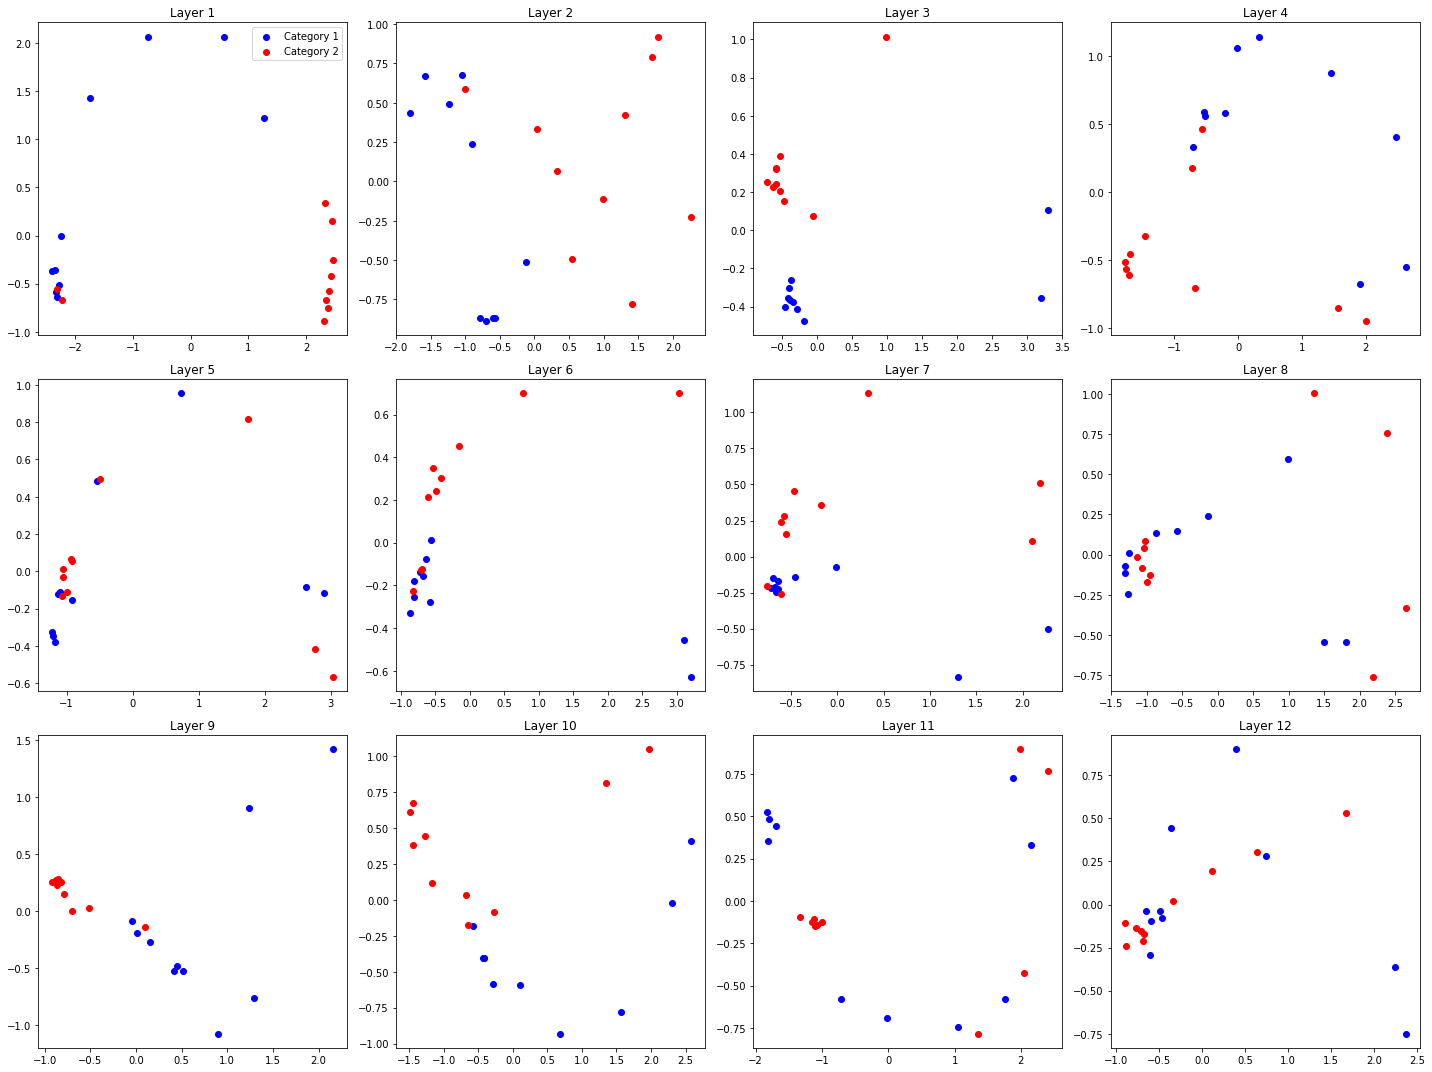

In [83]:

from sklearn.decomposition import PCA

# 假设 flattened_matrices 是你已经准备好的数据，形状为 (180, n_features)

n_layers = 12
n_samples_per_layer = 20
n_categories = 2  # 两种语料的类别

fig, axs = plt.subplots(3, 4, figsize=(20, 15))  # 准备一个3x4的子图网格来绘制每个层的t-SNE结果
axs = axs.flatten()  # 将子图数组拉平，方便索引

for i in range(n_layers):
    # 提取当前层的数据
    layer_data = flattened_matrices[i*n_samples_per_layer:(i+1)*n_samples_per_layer, :]
    
    # 应用t-SNE降维到2D，设置适当的perplexity值
    #tsne = TSNE(n_components=2, perplexity=min(10, n_samples_per_layer - 1), random_state=0)
    #tsne_results = tsne.fit_transform(layer_data)
    pca = PCA(n_components=2, random_state=0)
    pca_results = pca.fit_transform(layer_data)
    
    ax = axs[i]
    # 前10个语料一种颜色，后5个语料另一种颜色
    ax.scatter(pca_results[:10, 0], pca_results[:10, 1], color='blue', label='Category 1')
    ax.scatter(pca_results[10:, 0], pca_results[10:, 1], color='red', label='Category 2')
    
    ax.set_title(f'Layer {i+1}')
    if i == 0:  # 只在第一个子图中显示图例
        ax.legend()

plt.tight_layout()
plt.show()

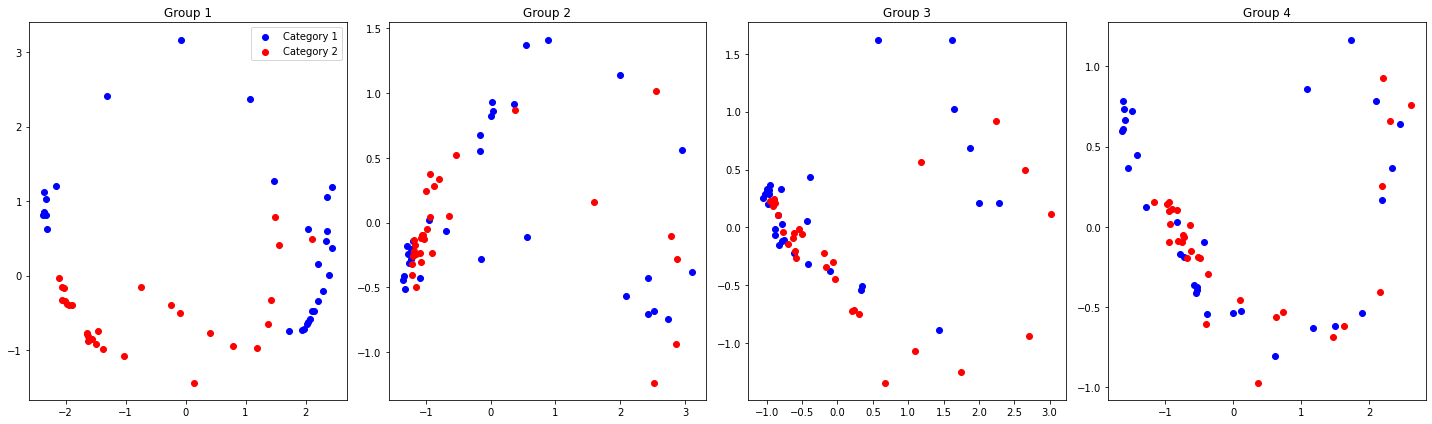

In [84]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# 假设 flattened_matrices 是你已经准备好的数据，形状为 (180, n_features)

n_groups = 2  # 将12个层分成3组，每组4个层
n_samples_per_group = n_samples_per_layer * 6  # 每组的样本数

fig, axs = plt.subplots(1, 2, figsize=(10, 6))  # 准备一个1x3的子图网格

for i in range(n_groups):
    # 提取当前组的数据
    group_data = flattened_matrices[i*n_samples_per_group:(i+1)*n_samples_per_group, :]
    
    # 应用t-SNE降维到2D，设置适当的perplexity值
    #tsne = TSNE(n_components=2, perplexity=min(30, n_samples_per_group // 4), random_state=0)
    #tsne_results = tsne.fit_transform(group_data)
    pca = PCA(n_components=2, random_state=0)
    pca_results = pca.fit_transform(group_data)
    
    ax = axs[i]
    # 每组内前40个语料一种颜色，后20个语料另一种颜色（因为每组有4个层）
    ax.scatter(pca_results[:30, 0], pca_results[:30, 1], color='blue', label='Category 1')
    ax.scatter(pca_results[30:, 0], pca_results[30:, 1], color='red', label='Category 2')
    
    ax.set_title(f'Group {i+1}')
    if i == 0:  # 只在第一个子图中显示图例
        ax.legend()

plt.tight_layout()
plt.show()


0
1
2
3
4
5
6
7
8
9
10
11


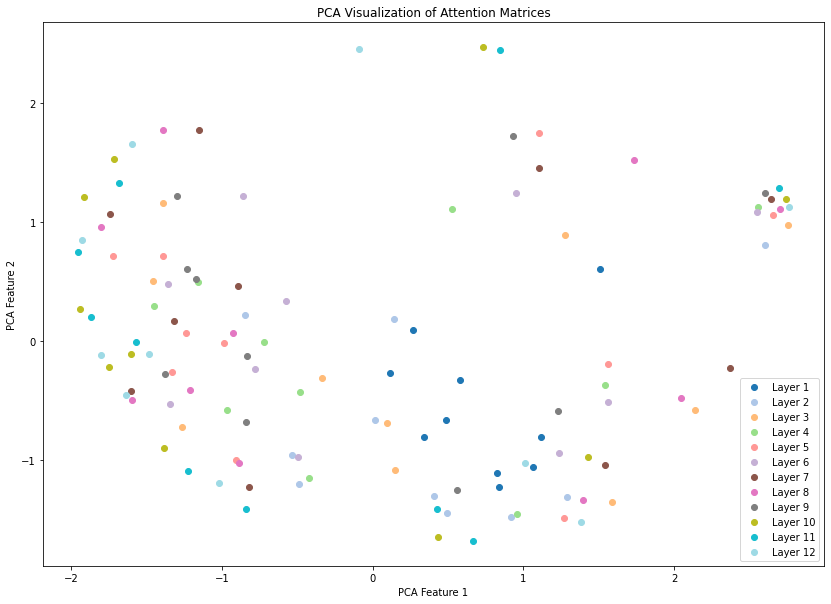

In [68]:
from sklearn.decomposition import PCA

# 假设 flattened_matrices 已经是你要处理的数据
# n_features 为拉平后的注意力矩阵的特征数

# 使用PCA进行降维
pca = PCA(n_components=2, random_state=0)
pca_results = pca.fit_transform(flattened_matrices)

# 可视化
plt.figure(figsize=(14, 10))
colors = plt.cm.tab20(np.linspace(0, 1, 12))  # 为12个层生成颜色
#layer_colors = np.array([colors[0]]*4 + [colors[1]]*4 + [colors[2]]*4)
#print(layer_colors)
for i, color in zip(range(12), colors):
    # 每个语料的每个层都有一个点，我们根据层来着色
    print(i)
    plt.scatter(pca_results[i::12, 0], pca_results[i::12, 1], color=color, label=f'Layer {i+1}')

plt.legend()
plt.title('PCA Visualization of Attention Matrices')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.show()

In [118]:
# 从cut_matrices中提取属于第7层到第12层的样本矩阵
layers_matrices1 = []
layers_matrices2 = []
for i, matrix in enumerate(flattened_matrices):
    layer = i % 12 + 1  # 确定当前矩阵属于哪一层

    if 10 <= layer <= 12 and i <= 119:
        print(i)
        layers_matrices1.append(matrix)
    elif 10 <= layer <= 12 and i > 119:
        layers_matrices2.append(matrix)
    else:
        pass

whole_matrices = layers_matrices1 + layers_matrices2

9
10
11
21
22
23
33
34
35
45
46
47
57
58
59
69
70
71
81
82
83
93
94
95
105
106
107
117
118
119


In [119]:
print(len(whole_matrices))

60


0
1


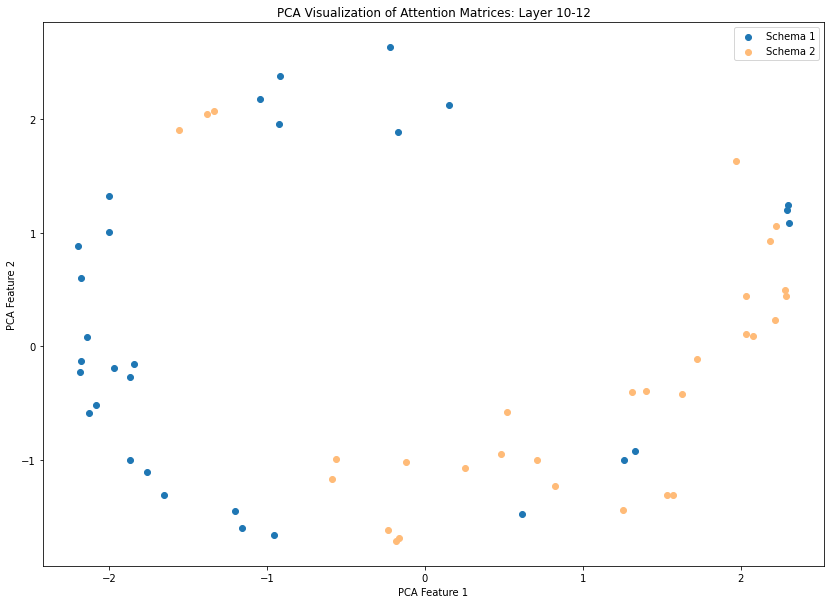

In [121]:
from sklearn.decomposition import PCA

# 假设 flattened_matrices 已经是你要处理的数据
# n_features 为拉平后的注意力矩阵的特征数

# 使用PCA进行降维
pca = PCA(n_components=2, random_state=0)
pca_results = pca.fit_transform(whole_matrices)

# 可视化
plt.figure(figsize=(14, 10))
colors = plt.cm.tab20(np.linspace(0, 1, 12))  # 为12个层生成颜色
layer_colors = np.array([colors[0]]*1 + [colors[2]]*1)
#print(layer_colors)
for i, color in zip(range(2), layer_colors):
    # 每个语料的每个层都有一个点，我们根据层来着色
    print(i)
    plt.scatter(pca_results[(0+i*30):(30+i*30), 0], pca_results[(0+i*30):(30+i*30), 1], color=color, label=f'Schema {i+1}')

plt.legend()
plt.title('PCA Visualization of Attention Matrices: Layer 10-12')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.show()

2. 尝试构建基于[CLS]的Sentence Embedding Matrix

torch.Size([4, 768])
torch.Size([4, 768])
torch.Size([4, 768])


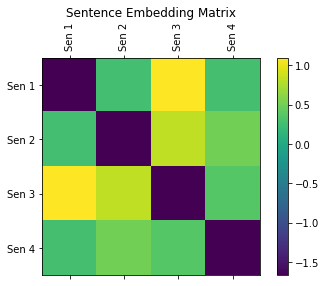

In [67]:
from sentence_transformers import SentenceTransformer, util
# 设置matplotlib字体以支持中文
#matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 或者您可以使用其他支持中文的字体
#matplotlib.rcParams['font.family']='sans-serif'

# 初始化分词器和模型
# 初始化分词器和模型
tokenizer = BertTokenizer.from_pretrained('F:/project/Attention/bert-base-chinese')
model = BertModel.from_pretrained('F:/project/Attention/bert-base-chinese', output_attentions=True).eval()

text = "穿过巴黎的大街，我来到了一家传统的法式餐厅，店门前摆放了薰衣草和干花。我选择了一个能看到街景的位置坐下，旁边正好是一堵涂鸦墙。当我翻看菜单时，服务员热情地为我推荐了鹅肝和鹅掌。很快，诱人的美食被送到我的眼前，配上一杯红酒，不失为一种享受。"
sentences = text.split('。')[:-1]  # 分割句子
#sentences = "[CLS] " + "[SEP] [CLS] ".join(sentences) + "[SEP]"

# Two lists of sentences
sentences1 = sentences
sentences2 = sentences

# 编码文本
inputs1 = tokenizer(sentences1, return_tensors="pt", padding=True, truncation=True, max_length=512)
inputs2 = tokenizer(sentences2, return_tensors="pt", padding=True, truncation=True, max_length=512)


with torch.no_grad():
    outputs1 = model(**inputs1)
    outputs2 = model(**inputs2)
    #outputs1 = outputs1["last_hidden_state"]
    #outputs2 = outputs2["last_hidden_state"]

def cls_pooling(model_input, attention_mask):
    #return model_input[0][:,0]
    print(model_input[1][:,].shape)
    return model_input[1][:,]

# Perform pooling. In this case, max pooling.
sentence_embeddings1 = cls_pooling(outputs1, inputs1['attention_mask'])
sentence_embeddings2 = cls_pooling(outputs2, inputs2['attention_mask'])

print(sentence_embeddings2.shape)

# Compute cosine-similarities
euclidean_distance = euclidean_distances(sentence_embeddings1, sentence_embeddings2)

similarity = euclidean_distance
# 计算平均值和标准差
mean = np.mean(similarity)
std = np.std(similarity)

# 进行Z-score归一化
similarity_normalized = (similarity - mean) / std

# 可视化
fig, ax = plt.subplots()
cax = ax.matshow(similarity_normalized, cmap='viridis')
fig.colorbar(cax)

# 设置标签以提高可读性
sentence_labels = ['Sen ' + str(i+1) for i in range(len(sentences))]
ax.set_xticks(range(len(sentences)))
ax.set_yticks(range(len(sentences)))
ax.set_xticklabels(sentence_labels, rotation=90)
ax.set_yticklabels(sentence_labels)

plt.title(f'Sentence Embedding Matrix')
plt.show()

2.1 [CLS] embedding矩阵多sample情况

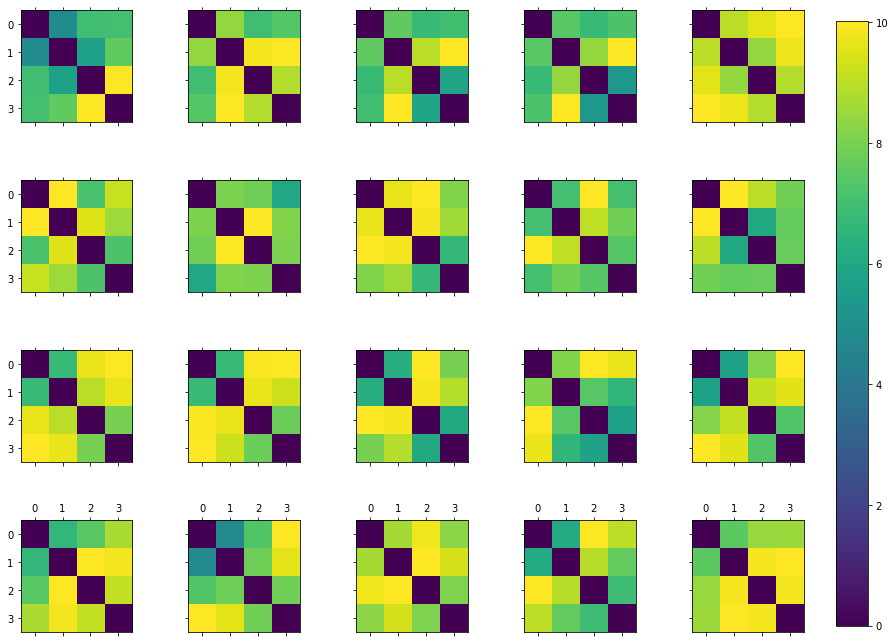

In [46]:
from sentence_transformers import util
from sklearn.metrics.pairwise import euclidean_distances

# 设置matplotlib字体以支持中文
#matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 或者您可以使用其他支持中文的字体
#matplotlib.rcParams['font.family']='sans-serif'

# 初始化分词器和模型
# 初始化分词器和模型
tokenizer = BertTokenizer.from_pretrained('F:/project/Attention/bert-base-chinese')
model = BertModel.from_pretrained('F:/project/Attention/bert-base-chinese', output_attentions=True).eval()

# 读取语料
with open("F:/project/Attention/corpus.txt", "r", encoding="utf-8") as file:
    corpus = [line.strip() for line in file.readlines()]


def cls_pooling(model_output, attention_mask):
    #return model_output[0][:,0]
    return model_output[1]

# 准备画布
fig, axs = plt.subplots(4, 5, figsize=(15, 12), sharex='col', sharey='row',
                        gridspec_kw={'wspace':0.5, 'hspace':0.2, 'right':0.85})

# 累积所有子图的attention矩阵，用于确定colorbar的范围
all_sim = []

for corpus_index, text in enumerate(corpus):
    sentences = text.split('。')[:-1]  # 分割句子

    # Two lists of sentences
    sentences1 = sentences
    sentences2 = sentences

    # 编码文本
    inputs1 = tokenizer(sentences1, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs2 = tokenizer(sentences2, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs1 = model(**inputs1)
        outputs2 = model(**inputs2)

    # Perform pooling. In this case, max pooling.
    sentence_embeddings1 = cls_pooling(outputs1, inputs1['attention_mask'])
    sentence_embeddings2 = cls_pooling(outputs2, inputs2['attention_mask'])

    # Compute cosine-similarities
    #cosine_scores = util.cos_sim(sentence_embeddings1, sentence_embeddings2)

    # 计算欧氏距离
    euclidean_distance = euclidean_distances(sentence_embeddings1, sentence_embeddings2)

    # 使用指数转换将欧氏距离转换为相似性度量
    #similarity = np.exp(-euclidean_distance)
    epsilon = 1e-5
    similarity = euclidean_distance
    # 计算平均值和标准差
    #mean = np.mean(similarity)
    #std = np.std(similarity)

    # 进行Z-score归一化
    #similarity_normalized = (similarity - mean) / std

    all_sim.append(similarity)
        
    row = corpus_index // 5  
    col = corpus_index % 5  
    ax = axs[row, col]
    im = ax.matshow(similarity, cmap='viridis')

    if col == 0:
        ax.set_yticks(range(1,len(sentences)+1))

# 创建一个大colorbar适用于所有子图
cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])  # 适当调整colorbar的位置和大小
fig.colorbar(im, cax=cbar_ax)



画20*20大矩阵

In [47]:
def transform_matrix(matrix):
    tril_indices = np.tril_indices_from(matrix, k=-1)
    transformed_matrix = np.full(matrix.shape, np.nan)  # 创建一个填充了NaN的矩阵
    transformed_matrix[tril_indices] = matrix[tril_indices]  # 只填充对角线和下三角
    return transformed_matrix

cut_matrices2 = []

for matrix in all_sim:
    # 将每个矩阵拉平
    cut_matrix = transform_matrix(matrix)
    cut_matrices2.append(cut_matrix)

print(cut_matrices2[0])

[[        nan         nan         nan         nan]
 [ 5.90010548         nan         nan         nan]
 [ 8.51365471  7.02753639         nan         nan]
 [ 8.58298588  9.26448822 12.25872803         nan]]


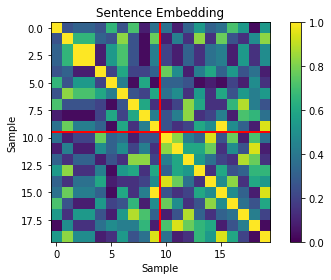

In [48]:
from scipy.stats import spearmanr
# 计算每一层的Spearman相关性矩阵
def calc_spearman_matrices(cut_matrices, layers=12, samples=20):
    layer_matrices = []
    for layer in range(layers):
        # 为当前层初始化一个空的15x15矩阵
        spearman_matrix = np.zeros((samples, samples))
        for i in range(samples):
            for j in range(samples):
                # 选取对应样本和层的矩阵
                matrix_i = cut_matrices[i*layers + layer]
                matrix_j = cut_matrices[j*layers + layer]
                flat_i = matrix_i.flatten()
                flat_j = matrix_j.flatten()
                valid_indices = ~np.isnan(flat_i) & ~np.isnan(flat_j)
                # 计算两个矩阵的Spearman相关性
                # 这里假设您是对矩阵所有元素进行比较
                m1 = (flat_i[valid_indices] - np.mean(flat_i[valid_indices]))/np.std(flat_i[valid_indices])
                m2 = (flat_j[valid_indices] - np.mean(flat_j[valid_indices]))/np.std(flat_j[valid_indices])
                rho, _ = spearmanr(m1, m2)
                spearman_matrix[i, j] = abs(rho)  # 只保留绝对值
        layer_matrices.append(spearman_matrix)
    return layer_matrices

# 计算每层的Spearman相关性矩阵
spearman_matrices = calc_spearman_matrices(cut_matrices2, 1, 20)


plt.imshow(spearman_matrices[0], cmap='viridis', vmin=0, vmax=1)
plt.title(f'Sentence Embedding')
plt.xlabel('Sample')
plt.ylabel('Sample')
plt.colorbar()
plt.axhline(y = 9.5, color = 'r', linestyle = '-', linewidth = 2)
plt.axvline(x = 9.5, color = 'r', linestyle = '-', linewidth = 2)
plt.tight_layout()
plt.show()

PCA看组间是否可分

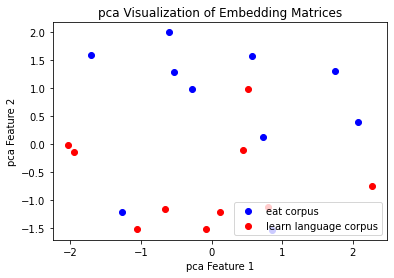

In [18]:
from sklearn.decomposition import PCA

flattened_matrices2 = []

for matrix in cut_matrices2:
    # 将每个矩阵拉平
    flattened_matrix = matrix.flatten()
    valid_indices = ~np.isnan(flattened_matrix)
    final = (flattened_matrix[valid_indices] - np.mean(flattened_matrix[valid_indices]))/np.std(flattened_matrix[valid_indices])
    flattened_matrices2.append(final)

# 将列表转换为numpy数组
flattened_matrices2 = np.array(flattened_matrices2)
# 现在 flattened_matrices 是形状为 (15, n_features) 的数组
# 其中 n_samples 为 15 

from sklearn.manifold import TSNE

# 假设 flattened_matrices 是你已经准备好的数据，形状为 (180, n_features)
n_samples = 20
n_categories = 2  # 两种语料的类别
    
# 应用t-SNE降维到2D，设置适当的perplexity值
#tsne = TSNE(n_components=2, perplexity=min(10, n_samples - 1), random_state=0)
#tsne_results = tsne.fit_transform(flattened_matrices)
pca = PCA(n_components=2, random_state=0)
pca_results = pca.fit_transform(flattened_matrices2)
    
# 前10个语料一种颜色，后5个语料另一种颜色
plt.scatter(pca_results[:10, 0], pca_results[:10, 1], color='blue', label='eat corpus')
plt.scatter(pca_results[10:, 0], pca_results[10:, 1], color='red', label='learn language corpus')

plt.legend(loc = "lower right")
plt.title('pca Visualization of Embedding Matrices')
plt.xlabel('pca Feature 1')
plt.ylabel('pca Feature 2')
plt.show()

2.2 尝试构建基于Avg的embeddings

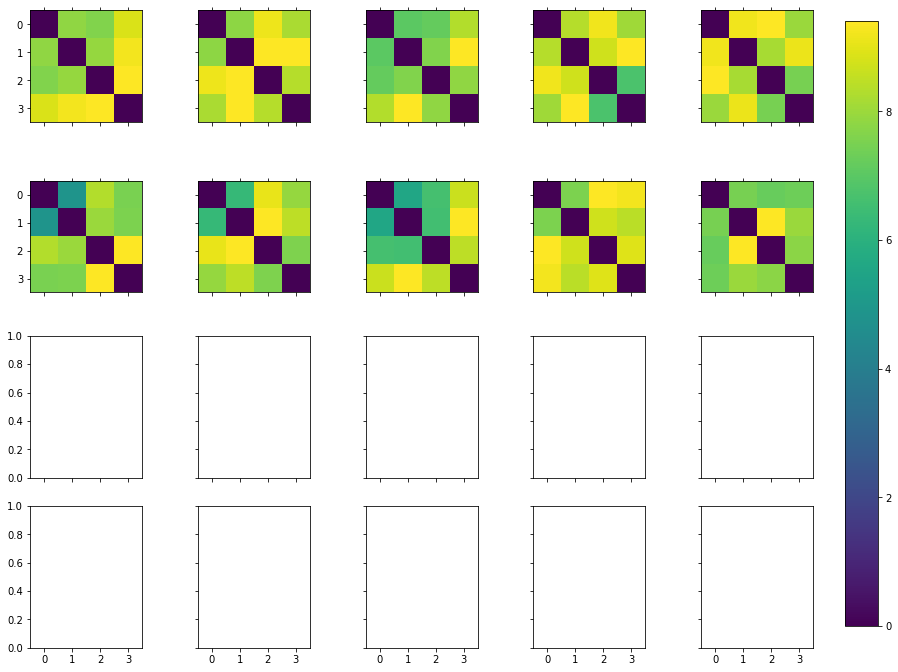

In [31]:
from sentence_transformers import util
from sklearn.metrics.pairwise import euclidean_distances

# 设置matplotlib字体以支持中文
#matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 或者您可以使用其他支持中文的字体
#matplotlib.rcParams['font.family']='sans-serif'

# 初始化分词器和模型
# 初始化分词器和模型
tokenizer = BertTokenizer.from_pretrained('F:/project/Attention/bert-base-chinese')
model = BertModel.from_pretrained('F:/project/Attention/bert-base-chinese', output_attentions=True).eval()

# 读取语料
with open("F:/project/Attention/corpus2.txt", "r", encoding="utf-8") as file:
    corpus = [line.strip() for line in file.readlines()]


def avg(model_output, attention_mask):
    return torch.mean(model_output[0], dim = 1)

# 准备画布
fig, axs = plt.subplots(4, 5, figsize=(15, 12), sharex='col', sharey='row',
                        gridspec_kw={'wspace':0.5, 'hspace':0.2, 'right':0.85})

# 累积所有子图的attention矩阵，用于确定colorbar的范围
all_sim = []

for corpus_index, text in enumerate(corpus):
    sentences = text.split('。')[:-1]  # 分割句子

    # Two lists of sentences
    sentences1 = sentences
    sentences2 = sentences

    # 编码文本
    inputs1 = tokenizer(sentences1, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs2 = tokenizer(sentences2, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs1 = model(**inputs1)
        outputs2 = model(**inputs2)

    # Perform pooling. In this case, max pooling.
    sentence_embeddings1 = avg(outputs1, inputs1['attention_mask'])
    sentence_embeddings2 = avg(outputs2, inputs2['attention_mask'])

    # Compute cosine-similarities
    #cosine_scores = util.cos_sim(sentence_embeddings1, sentence_embeddings2)

    # 计算欧氏距离
    euclidean_distance = euclidean_distances(sentence_embeddings1, sentence_embeddings2)

    # 使用指数转换将欧氏距离转换为相似性度量
    #similarity = np.exp(-euclidean_distance)
    epsilon = 1e-5
    similarity = euclidean_distance
    # 计算平均值和标准差
    #mean = np.mean(similarity)
    #std = np.std(similarity)

    # 进行Z-score归一化
    #similarity_normalized = (similarity - mean) / std

    all_sim.append(similarity)
        
    row = corpus_index // 5  
    col = corpus_index % 5  
    ax = axs[row, col]
    im = ax.matshow(similarity, cmap='viridis')

    if col == 0:
        ax.set_yticks(range(1,len(sentences)+1))

# 创建一个大colorbar适用于所有子图
cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])  # 适当调整colorbar的位置和大小
fig.colorbar(im, cax=cbar_ax)

Stopwords 情况

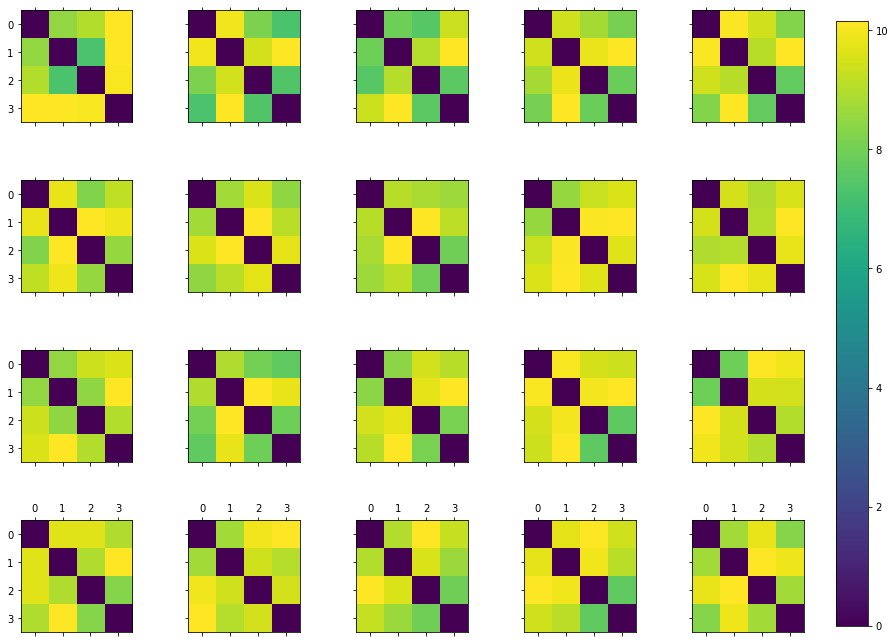

In [76]:
from sklearn.metrics.pairwise import euclidean_distances

cn_stopwords_path = 'F:/project/Attention/cn_stopwords.txt'  # 停词文件的路径
with open(cn_stopwords_path, 'r', encoding='utf-8') as f:
    cn_stopwords = {line.strip() for line in f.readlines()}

# 初始化分词器和模型
tokenizer = BertTokenizer.from_pretrained('F:/project/Attention/bert-base-chinese')
model = BertModel.from_pretrained('F:/project/Attention/bert-base-chinese', output_attentions=True).eval()

# 读取语料
with open("F:/project/Attention/corpus.txt", "r", encoding="utf-8") as file:
    corpus = [line.strip() for line in file.readlines()]
  

def avg(model_output, attention_mask, tokens, stopwords):
    """
    计算除了停用词之外的token嵌入的平均值。
    :param model_output: 模型的输出。
    :param attention_mask: 注意力遮罩，用于识别padding的部分。
    :param tokens: token列表。
    :param stopwords: 停用词集合。
    :return: 停用词过滤后的平均嵌入。
    """
    token_embeddings = model_output[0]  # 第一个输出是最后一层的隐藏状态，形状为[batch_size, seq_length, hidden_size]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.zeros(token_embeddings[:,0,:].shape)
    valid_tokens = torch.zeros(token_embeddings[:,0,:].shape)
    
    for i, token in enumerate(tokens):
        if token not in stopwords and token not in ['[CLS]', '[SEP]', '[PAD]']:  # 过滤掉特殊token和停用词
            sum_embeddings += token_embeddings[:,i,:] * input_mask_expanded[:,i,:]
            valid_tokens += input_mask_expanded[:,i,:]
    
    avg_embeddings = sum_embeddings / valid_tokens.clamp(min=1)  # 防止除以0
    return avg_embeddings

# 准备画布
fig, axs = plt.subplots(4, 5, figsize=(15, 12), sharex='col', sharey='row',
                        gridspec_kw={'wspace':0.5, 'hspace':0.2, 'right':0.85})

# 累积所有子图的attention矩阵，用于确定colorbar的范围
all_sim = []

for corpus_index, text in enumerate(corpus):  # 假设我们只处理前10个句子作为示例
    sentences = text.split('。')[:-1]  # 分割句子
    if not sentences: continue  # 如果分割后没有句子，跳过此次循环

    # 为了简化，我们将sentences1和sentences2设置为相同的句子列表
    sentences1 = sentences
    sentences2 = sentences

    inputs1 = tokenizer(sentences1, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs2 = tokenizer(sentences2, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs1 = model(**inputs1)
        outputs2 = model(**inputs2)

    # 获取tokens
    tokens1 = [tokenizer.convert_ids_to_tokens(id) for id in inputs1['input_ids'].tolist()][0]  # 假设batch_size=1
    tokens2 = [tokenizer.convert_ids_to_tokens(id) for id in inputs2['input_ids'].tolist()][0]  # 假设batch_size=1

    # 计算排除停用词后的句子嵌入
    sentence_embeddings1 = avg(outputs1, inputs1['attention_mask'], tokens1, cn_stopwords)
    sentence_embeddings2 = avg(outputs2, inputs2['attention_mask'], tokens2, cn_stopwords)

        # 计算欧氏距离
    euclidean_distance = euclidean_distances(sentence_embeddings1, sentence_embeddings2)

    # 使用指数转换将欧氏距离转换为相似性度量
    #similarity = np.exp(-euclidean_distance)
    epsilon = 1e-5
    similarity = euclidean_distance
    # 计算平均值和标准差
    #mean = np.mean(similarity)
    #std = np.std(similarity)

    # 进行Z-score归一化
    #similarity_normalized = (similarity - mean) / std

    all_sim.append(similarity)
        
    row = corpus_index // 5  
    col = corpus_index % 5  
    ax = axs[row, col]
    im = ax.matshow(similarity, cmap='viridis')

    if col == 0:
        ax.set_yticks(range(1,len(sentences)+1))

# 创建一个大colorbar适用于所有子图
cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])  # 适当调整colorbar的位置和大小
fig.colorbar(im, cax=cbar_ax)


In [33]:
def transform_matrix(matrix):
    tril_indices = np.tril_indices_from(matrix, k=-1)
    transformed_matrix = np.full(matrix.shape, np.nan)  # 创建一个填充了NaN的矩阵
    transformed_matrix[tril_indices] = matrix[tril_indices]  # 只填充对角线和下三角
    return transformed_matrix

cut_matrices2 = []

for matrix in all_sim:
    # 将每个矩阵拉平
    cut_matrix = transform_matrix(matrix)
    cut_matrices2.append(cut_matrix)

print(cut_matrices2[1])

[[       nan        nan        nan        nan]
 [7.00063848        nan        nan        nan]
 [8.21952057 8.44070339        nan        nan]
 [7.35447168 8.41280842 7.49009323        nan]]


[7.43787098 7.25327635 7.53155422 8.41940689 8.77010441 8.92849159]
[ 9.30820179  6.63572359  8.07936192  6.81364393 12.23256016  8.80943966]
[7.05058241 6.68402338 8.0648632  8.75220966 9.12402725 8.37287712]
[8.04777813 8.8599968  8.41611195 7.75372458 9.05569935 6.49616766]
[7.51321793 7.66845036 6.66799974 6.51727724 7.43818951 6.10241795]
[7.67881298 7.65253687 9.42231369 8.56486797 9.53825378 9.10201836]
[ 8.06218529  8.4396019  10.10629845  7.64964485  8.78567123  9.42368221]
[7.69444656 7.40941143 9.53386116 7.57356167 8.12414646 7.54540539]
[7.00063848 8.21952057 8.44070339 7.35447168 8.41280842 7.49009323]
[7.25152111 7.41999912 7.87424898 8.57065678 9.70066357 8.09411144]
[ 6.39743662  7.62000513  7.53206205  9.91812611 10.79538536  9.69908142]
[7.46286821 7.19915628 9.39688301 7.30625725 7.97008038 7.78137732]
[6.53772879 8.30410957 9.64469242 6.26154613 7.5090127  7.20042038]
[ 8.13828564  7.58038521  9.87787819  7.52752781 10.44079876  6.36880302]
[ 5.22251558  8.89296055

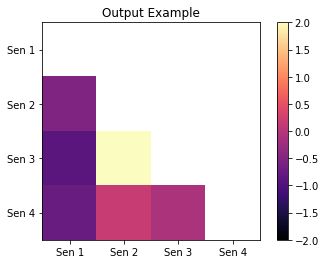

In [10]:
for matrix in cut_matrices2:
    lower_indices = np.tril_indices_from(matrix, k=-1)
    print(matrix[lower_indices])
    matrix[lower_indices] = (matrix[lower_indices] - np.mean(matrix[lower_indices])) / np.std(matrix[lower_indices])


print(cut_matrices2[11])

plt.imshow(cut_matrices2[11], cmap = "magma", vmin = -2, vmax = 2)
plt.xticks(range(4), ['Sen 1', 'Sen 2', 'Sen 3', 'Sen 4'])
plt.yticks(range(4), ['Sen 1', 'Sen 2', 'Sen 3', 'Sen 4'])
plt.title('Output Example')
plt.colorbar()

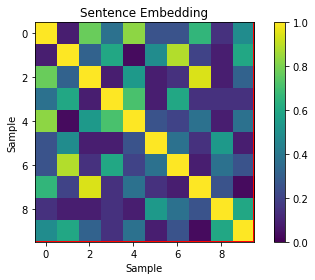

In [34]:
from scipy.stats import spearmanr
# 计算每一层的Spearman相关性矩阵
def calc_spearman_matrices(cut_matrices, layers=12, samples=15):
    layer_matrices = []
    for layer in range(layers):
        # 为当前层初始化一个空的15x15矩阵
        spearman_matrix = np.zeros((samples, samples))
        for i in range(samples):
            for j in range(samples):
                # 选取对应样本和层的矩阵
                matrix_i = cut_matrices[i*layers + layer]
                matrix_j = cut_matrices[j*layers + layer]
                flat_i = matrix_i.flatten()
                flat_j = matrix_j.flatten()
                valid_indices = ~np.isnan(flat_i) & ~np.isnan(flat_j)
                # 计算两个矩阵的Spearman相关性
                # 这里假设您是对矩阵所有元素进行比较
                m1 = (flat_i[valid_indices] - np.mean(flat_i[valid_indices]))/np.std(flat_i[valid_indices])
                m2 = (flat_j[valid_indices] - np.mean(flat_j[valid_indices]))/np.std(flat_j[valid_indices])
                rho, _ = spearmanr(m1, m2)
                spearman_matrix[i, j] = abs(rho)  # 只保留绝对值
        layer_matrices.append(spearman_matrix)
    return layer_matrices

# 计算每层的Spearman相关性矩阵
spearman_matrices = calc_spearman_matrices(cut_matrices2, 1, 10)


plt.imshow(spearman_matrices[0], cmap='viridis', vmin=0, vmax=1)
plt.title(f'Sentence Embedding')
plt.xlabel('Sample')
plt.ylabel('Sample')
plt.colorbar()
plt.axhline(y = 9.5, color = 'r', linestyle = '-', linewidth = 2)
plt.axvline(x = 9.5, color = 'r', linestyle = '-', linewidth = 2)
plt.tight_layout()
plt.show()

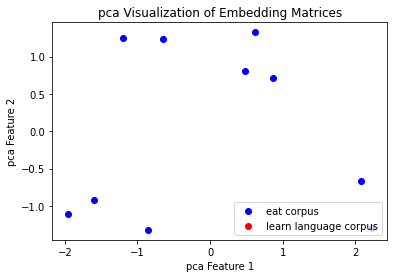

In [35]:
from sklearn.decomposition import PCA

flattened_matrices2 = []

for matrix in cut_matrices2:
    # 将每个矩阵拉平
    flattened_matrix = matrix.flatten()
    valid_indices = ~np.isnan(flattened_matrix)
    final = (flattened_matrix[valid_indices] - np.mean(flattened_matrix[valid_indices]))/np.std(flattened_matrix[valid_indices])
    flattened_matrices2.append(final)

# 将列表转换为numpy数组
flattened_matrices2 = np.array(flattened_matrices2)
# 现在 flattened_matrices 是形状为 (15, n_features) 的数组
# 其中 n_samples 为 15 

from sklearn.manifold import TSNE

# 假设 flattened_matrices 是你已经准备好的数据，形状为 (180, n_features)
n_samples = 10
n_categories = 2  # 两种语料的类别
    
# 应用t-SNE降维到2D，设置适当的perplexity值
#tsne = TSNE(n_components=2, perplexity=min(10, n_samples - 1), random_state=0)
#tsne_results = tsne.fit_transform(flattened_matrices)
pca = PCA(n_components=2, random_state=0)
pca_results = pca.fit_transform(flattened_matrices2)
    
# 前10个语料一种颜色，后5个语料另一种颜色
plt.scatter(pca_results[:10, 0], pca_results[:10, 1], color='blue', label='eat corpus')
plt.scatter(pca_results[10:, 0], pca_results[10:, 1], color='red', label='learn language corpus')

plt.legend(loc = "lower right")
plt.title('pca Visualization of Embedding Matrices')
plt.xlabel('pca Feature 1')
plt.ylabel('pca Feature 2')
plt.show()

In [36]:
save_path = 'F:/project/Attention/fMRI_process/Dataset/MyData/gpt2-emb.txt'
# 确保只保存前20个矩阵，如果数量不足20个，则保存实际数量
np.savetxt(save_path, flattened_matrices2[:20], fmt='%f')  # fmt='%f' 指定保存为浮点数格式
print(f'emb matrices saved to {save_path}')

emb matrices saved to F:/project/Attention/fMRI_process/Dataset/MyData/gpt2-emb.txt


3. Attention与Embedding比较

3.1 [CLS]

In [23]:
print(avg_emb_type1)
print(avg_emb_type2)

rho, _ = spearmanr(avg_emb_type1.flatten(), avg_emb_type2.flatten())

print(rho)

[-1.6548812   0.5505869   0.53513956  0.41942725  0.5505869  -1.6548812
  0.6656832   0.73469245  0.53513956  0.6656832  -1.6548812   0.40423328
  0.41942725  0.73469245  0.40423328 -1.6548811 ]
[-1.651933    0.09673737  0.7070451   0.74696356  0.09673737 -1.651933
  0.7280923   0.69215244  0.7070451   0.7280923  -1.651933    0.33287552
  0.74696356  0.69215244  0.33287552 -1.651933  ]
0.5637238429588571


In [17]:
print(np.mean(flattened_matrices2[:10], axis=0))

[-1.65488126  0.55058693 -1.65488124  0.53513956  0.66568319 -1.65488126
  0.41942726  0.7346925   0.40423324 -1.65488124]


In [12]:
avg_emb_type1 = np.mean(flattened_matrices2[:10], axis=0)
avg_emb_type2 = np.mean(flattened_matrices2[10:], axis=0)

from scipy.stats import spearmanr

# 假设 all_attentions 是一个包含180个4x4矩阵的列表
# 每15个矩阵代表一个层，其中前10个是一类，后5个是另一类

n_layers = 12
n_samples_per_layer = 20
spearman_scores1 = []
spearman_scores2 = []
spearman_scores3 = []
spearman_scores4 = []
pvalue1 = []
pvalue2 = []
pvalue3 = []
pvalue4 = []
layers = range(1, n_layers + 1)

for i in range(n_layers):
    # 提取当前层的矩阵
    current_layer_matrices = []
    # 遍历每个样本
    for sample in range(n_samples):
        # 计算当前层在flattened_matrices中的索引位置
        index = sample * n_layers + i
        current_layer_matrices.append(flattened_matrices[index])
    
    # 计算两个类别的平均矩阵
    avg_matrix_type1 = np.mean(current_layer_matrices[:10], axis=0)
    avg_matrix_type2 = np.mean(current_layer_matrices[10:], axis=0)
    
    # 计算两个平均矩阵之间的Spearman相关系数
    rho1, p1 = spearmanr(avg_matrix_type1, avg_matrix_type2)
    spearman_scores1.append(abs(rho1))
    pvalue1.append(p1)

    rho2, p2 = spearmanr(avg_matrix_type1, avg_emb_type1)
    spearman_scores2.append(abs(rho2))
    pvalue2.append(p2)

    rho3, p3 = spearmanr(avg_matrix_type2, avg_emb_type2)
    spearman_scores3.append(abs(rho3))
    pvalue3.append(p3)

    rho4, p4 = spearmanr(avg_emb_type1, avg_emb_type2)
    spearman_scores4.append(abs(rho4))
    pvalue4.append(p4)

# 绘制折线图展示Spearman分数
significance_threshold = 0.05

plt.figure(figsize=(10, 6))
plt.axhline(y=0.5, linestyle="--", color='gray')
plt.plot(range(1, n_layers + 1), spearman_scores1, marker='o', linestyle='-', label='Att: eat VS learn lang')
plt.plot(range(1, n_layers + 1), spearman_scores2, marker='o', linestyle='-', label='Att eat VS Emb eat')
plt.plot(range(1, n_layers + 1), spearman_scores3, marker='o', linestyle='-', label='Att learn lang VS Emb learn lang')
plt.plot(range(1, n_layers + 1), spearman_scores4, marker='o', linestyle='-', label='Emb eat VS Emb learn lang')
# 对于每一层，检查p值，并在图上标注显著的得分
for i, layer in enumerate(layers):
    if i == 3:
        print(pvalue1[i], pvalue2[i], pvalue3[i], pvalue4[i])
    if pvalue1[i] < significance_threshold:
        plt.plot(layer, spearman_scores1[i], marker='*', color='black')
    if pvalue2[i] < significance_threshold:
        plt.plot(layer, spearman_scores2[i], marker='*', color='black')
    if pvalue3[i] < significance_threshold:
        plt.plot(layer, spearman_scores3[i], marker='*', color='black')
    if pvalue4[i] < significance_threshold:
        plt.plot(layer, spearman_scores4[i], marker='*', color='black')

plt.xlabel('Layer')
plt.ylabel('Abs Spearman Correlation Score')
plt.title('Spearman Correlation Score Between Two Types Across Layers')
plt.legend(loc = "upper left")
plt.xticks(range(1, n_layers + 1))  # 设置x轴的刻度
plt.grid(True)
plt.show()


NameError: name 'flattened_matrices2' is not defined

3.2 Avg

0.1107871720116617 0.46847813411078715 0.9571545189504373 0.1107871720116617


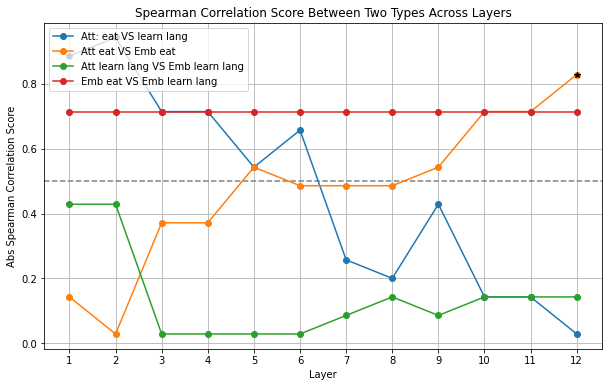

In [20]:
avg_emb_type1 = np.mean(flattened_matrices2[:10], axis=0)
avg_emb_type2 = np.mean(flattened_matrices2[10:], axis=0)

from scipy.stats import spearmanr

# 假设 all_attentions 是一个包含180个4x4矩阵的列表
# 每15个矩阵代表一个层，其中前10个是一类，后5个是另一类

n_layers = 12
n_samples_per_layer = 20
spearman_scores1 = []
spearman_scores2 = []
spearman_scores3 = []
spearman_scores4 = []
pvalue1 = []
pvalue2 = []
pvalue3 = []
pvalue4 = []
layers = range(1, n_layers + 1)

for i in range(n_layers):
    # 提取当前层的矩阵
    current_layer_matrices = []
    # 遍历每个样本
    for sample in range(n_samples):
        # 计算当前层在flattened_matrices中的索引位置
        index = sample * n_layers + i
        current_layer_matrices.append(flattened_matrices[index])

    
    # 计算两个类别的平均矩阵
    avg_matrix_type1 = np.mean(current_layer_matrices[:10], axis=0)
    avg_matrix_type2 = np.mean(current_layer_matrices[10:], axis=0)
    
    # 计算两个平均矩阵之间的Spearman相关系数
    rho1, p1 = spearmanr(avg_matrix_type1, avg_matrix_type2)
    spearman_scores1.append(abs(rho1))
    pvalue1.append(p1)

    rho2, p2 = spearmanr(avg_matrix_type1, avg_emb_type1)
    spearman_scores2.append(abs(rho2))
    pvalue2.append(p2)

    rho3, p3 = spearmanr(avg_matrix_type2, avg_emb_type2)
    spearman_scores3.append(abs(rho3))
    pvalue3.append(p3)

    rho4, p4 = spearmanr(avg_emb_type1, avg_emb_type2)
    spearman_scores4.append(abs(rho4))
    pvalue4.append(p4)

# 绘制折线图展示Spearman分数
significance_threshold = 0.05

plt.figure(figsize=(10, 6))
plt.axhline(y=0.5, linestyle="--", color='gray')
plt.plot(range(1, n_layers + 1), spearman_scores1, marker='o', linestyle='-', label='Att: eat VS learn lang')
plt.plot(range(1, n_layers + 1), spearman_scores2, marker='o', linestyle='-', label='Att eat VS Emb eat')
plt.plot(range(1, n_layers + 1), spearman_scores3, marker='o', linestyle='-', label='Att learn lang VS Emb learn lang')
plt.plot(range(1, n_layers + 1), spearman_scores4, marker='o', linestyle='-', label='Emb eat VS Emb learn lang')
# 对于每一层，检查p值，并在图上标注显著的得分
for i, layer in enumerate(layers):
    if i == 3:
        print(pvalue1[i], pvalue2[i], pvalue3[i], pvalue4[i])
    if pvalue1[i] < significance_threshold:
        plt.plot(layer, spearman_scores1[i], marker='*', color='black')
    if pvalue2[i] < significance_threshold:
        plt.plot(layer, spearman_scores2[i], marker='*', color='black')
    if pvalue3[i] < significance_threshold:
        plt.plot(layer, spearman_scores3[i], marker='*', color='black')
    if pvalue4[i] < significance_threshold:
        plt.plot(layer, spearman_scores4[i], marker='*', color='black')

plt.xlabel('Layer')
plt.ylabel('Abs Spearman Correlation Score')
plt.title('Spearman Correlation Score Between Two Types Across Layers')
plt.legend(loc = "upper left")
plt.xticks(range(1, n_layers + 1))  # 设置x轴的刻度
plt.grid(True)
plt.show()


----------------------------一些杂乱的尝试-----------------------------------------

In [ ]:
import AttentionVisualizer as av

obj = av.AttentionVisualizer()

obj.show_controllers(with_sample=False)

In [111]:

# 设置matplotlib字体以支持中文
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 或者您可以使用其他支持中文的字体
matplotlib.rcParams['font.family']='sans-serif'

# 初始化分词器和模型
tokenizer = BertTokenizer.from_pretrained('F:/project/Attention/bert-base-chinese')
model = BertModel.from_pretrained('F:/project/Attention/bert-base-chinese', output_attentions=True).eval()

# 输入
#marked_sentence = "小明停车。他走进餐馆, 吃了一碗面。"

sentence1 = "小明停车"
sentence2 = "他走进餐馆"
sentence3 = "吃了一碗面"
marked_sentence = "[CLS] "+ sentence1 + " [SEP]" + sentence2 + " [SEP]" + sentence3 + " [SEP]"

tokenized_text = tokenizer.tokenize(marked_sentence)
tokens = tokenized_text
input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
input_ids = torch.tensor([input_ids])
segments_ids = [1] * len(tokenized_text)
segments_ids = torch.tensor([segments_ids])

# 编码并获取注意力得分
with torch.no_grad():
    outputs = model(input_ids, token_type_ids=segments_ids)
    attentions = outputs.attentions



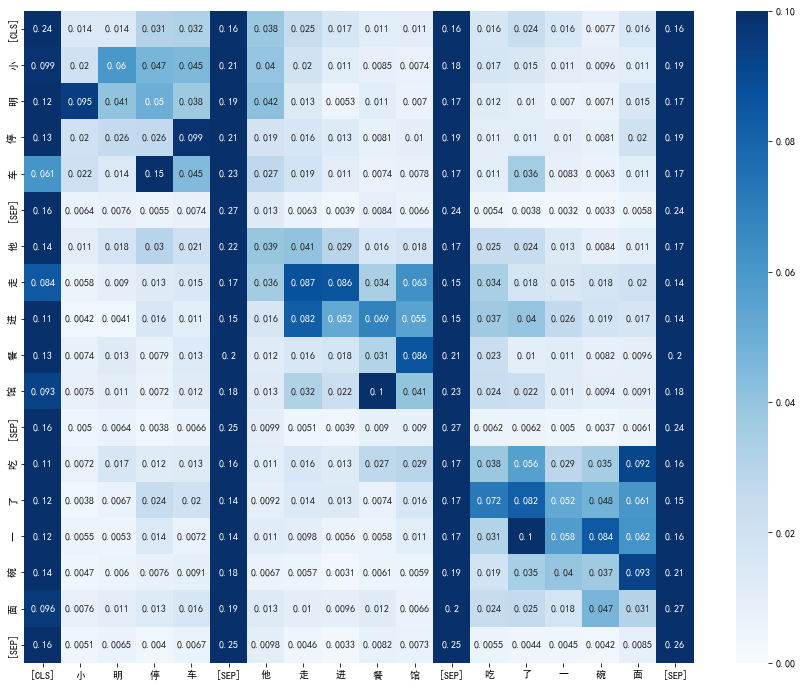

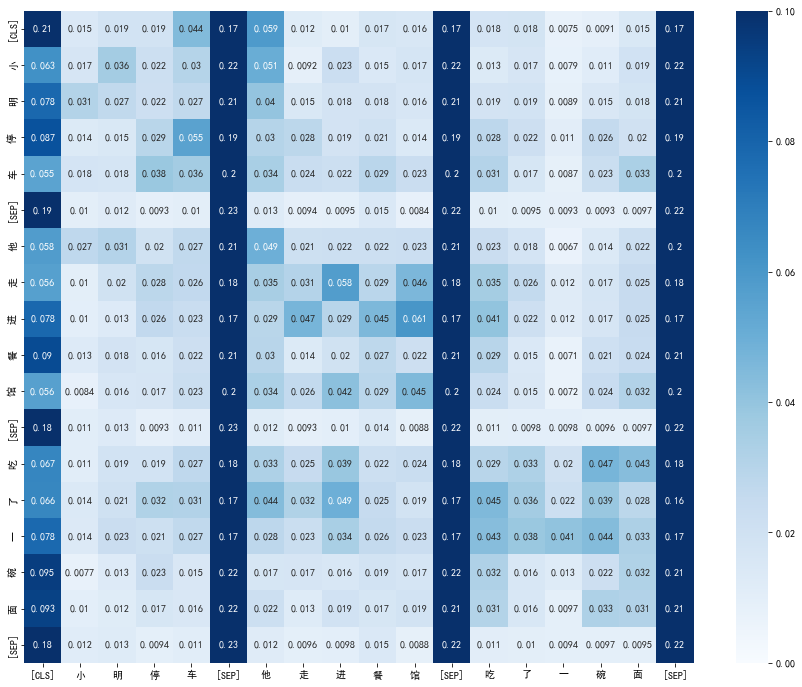

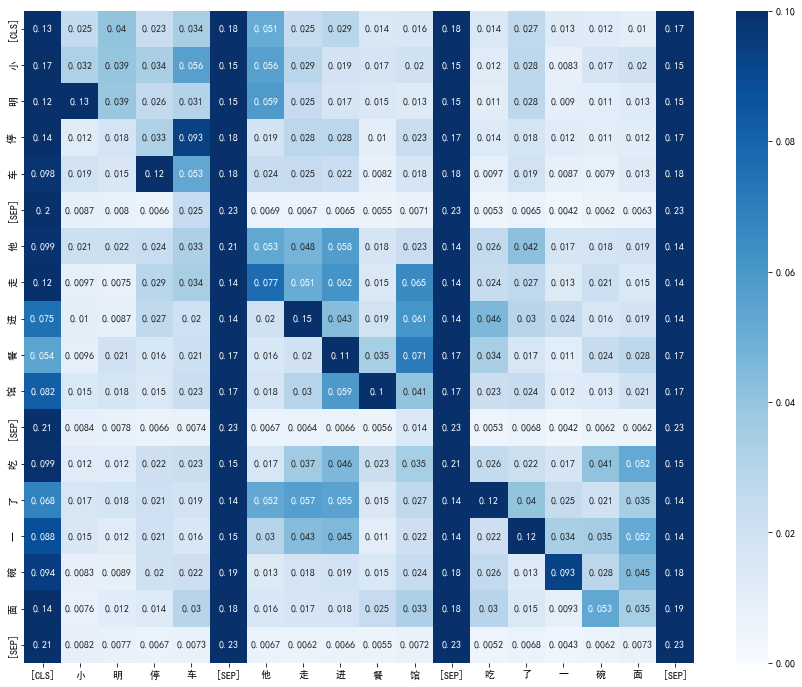

In [113]:
def plot_attention(attention, tokens):
    # 使用Seaborn绘制热图
    plt.figure(figsize=(15, 12))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, annot=True, cmap='Blues', vmin=0, vmax=0.1)
    plt.show()

# 假设您已经有了tokens和attentions
avg_attention = np.mean([layer[0].detach().numpy() for layer in attentions], axis=0)
attention12 = attentions[11][0, 0].detach().numpy()
attention6 = attentions[5][0, 0].detach().numpy()
attention1 = attentions[0][0, 0].detach().numpy()

# 可视化
'''
plot_attention(attention12[1:17,1:17], tokens[1:17])
plot_attention(attention6[1:17,1:17], tokens[1:17])
plot_attention(attention1[1:17,1:17], tokens[1:17])
'''

plot_attention(avg_attention[11], tokens)
plot_attention(avg_attention[5], tokens)
plot_attention(avg_attention[0], tokens)

In [ ]:

# 设置matplotlib字体以支持中文
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 或者您可以使用其他支持中文的字体
matplotlib.rcParams['font.family']='sans-serif'

# 初始化分词器和模型
tokenizer = BertTokenizer.from_pretrained('F:/project/Attention/bert-base-chinese')
model = BertModel.from_pretrained('F:/project/Attention/bert-base-chinese', output_attentions=True).eval()

# 输入
marked_sentence = "小明停车。他走进餐馆, 吃了一碗面。"

tokenized_text = tokenizer.tokenize(marked_sentence)
tokens = tokenized_text
input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
input_ids = torch.tensor([input_ids])
segments_ids = [1] * len(tokenized_text)
segments_ids = torch.tensor([segments_ids])

# 编码并获取注意力得分
with torch.no_grad():
    outputs = model(input_ids, token_type_ids=segments_ids)
    attentions = outputs.attentions

def plot_attention(attention, tokens):
    # 使用Seaborn绘制热图
    plt.figure(figsize=(15, 12))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, annot=True, cmap='Blues', vmin=0, vmax=0.2)
    plt.show()

# 假设您已经有了tokens和attentions
avg_attention = np.mean([layer[0].detach().numpy() for layer in attentions], axis=0)
attention12 = attentions[11][0, 0].detach().numpy()
attention6 = attentions[5][0, 0].detach().numpy()
attention1 = attentions[0][0, 0].detach().numpy()

# 可视化
'''
plot_attention(attention12[1:17,1:17], tokens[1:17])
plot_attention(attention6[1:17,1:17], tokens[1:17])
plot_attention(attention1[1:17,1:17], tokens[1:17])
'''

plot_attention(avg_attention[11], tokens)
plot_attention(avg_attention[5], tokens)
plot_attention(avg_attention[0], tokens)


In [ ]:

# 设置matplotlib字体以支持中文
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 或者您可以使用其他支持中文的字体
matplotlib.rcParams['font.family']='sans-serif'

# 初始化分词器和模型
tokenizer = BertTokenizer.from_pretrained('F:/project/Attention/bert-base-chinese')
model = BertModel.from_pretrained('F:/project/Attention/bert-base-chinese', output_attentions=True).eval()

# 输入
marked_sentence = "小明停车。他走进餐馆。他吃了一碗面。"

tokenized_text = tokenizer.tokenize(marked_sentence)
tokens = tokenized_text
input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
input_ids = torch.tensor([input_ids])
segments_ids = [1] * len(tokenized_text)
segments_ids = torch.tensor([segments_ids])

# 编码并获取注意力得分
with torch.no_grad():
    outputs = model(input_ids, token_type_ids=segments_ids)
    attentions = outputs.attentions

def plot_attention(attention, tokens):
    # 使用Seaborn绘制热图
    plt.figure(figsize=(15, 12))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, annot=True, cmap='Blues', vmin=0, vmax=0.2)
    plt.show()

# 假设您已经有了tokens和attentions
avg_attention = np.mean([layer[0].detach().numpy() for layer in attentions], axis=0)
attention12 = attentions[11][0, 0].detach().numpy()
attention6 = attentions[5][0, 0].detach().numpy()
attention1 = attentions[0][0, 0].detach().numpy()

# 可视化
'''
plot_attention(attention12[1:17,1:17], tokens[1:17])
plot_attention(attention6[1:17,1:17], tokens[1:17])
plot_attention(attention1[1:17,1:17], tokens[1:17])
'''

plot_attention(avg_attention[11], tokens)
plot_attention(avg_attention[5], tokens)
plot_attention(avg_attention[0], tokens)


In [117]:

# 设置matplotlib字体以支持中文
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 或者您可以使用其他支持中文的字体
matplotlib.rcParams['font.family']='sans-serif'

# 初始化分词器和模型
tokenizer = BertTokenizer.from_pretrained('F:/project/Attention/gpt2-chinese-cluecorpussmall')
model = GPT2LMHeadModel.from_pretrained('F:/project/Attention/gpt2-chinese-cluecorpussmall', output_attentions=True).eval()

# 输入
marked_sentence = "小明停车。他走进餐馆，吃了一碗面。"
'''
sentence1 = "小明停车"
sentence2 = "他走进餐馆"
sentence3 = "吃了一碗面"
marked_sentence = "[CLS] "+ sentence1 + " [SEP]" + sentence2 + " [SEP]" + sentence3 + " [SEP]"
'''
tokenized_text = tokenizer.tokenize(marked_sentence)
tokens = tokenized_text
input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
input_ids = torch.tensor([input_ids])
segments_ids = [1] * len(tokenized_text)
segments_ids = torch.tensor([segments_ids])

# 编码并获取注意力得分
with torch.no_grad():
    outputs = model(input_ids, token_type_ids=segments_ids)
    attentions = outputs.attentions


In [ ]:
def plot_attention(attention, tokens):
    # 使用Seaborn绘制热图
    plt.figure(figsize=(15, 12))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, annot=True, cmap='Blues', vmin=0, vmax=0.13)
    plt.show()

# 假设您已经有了tokens和attentions
avg_attention = np.mean([layer[0].detach().numpy() for layer in attentions], axis=0)

# 可视化
plot_attention(avg_attention[11], tokens)
plot_attention(avg_attention[5], tokens)
plot_attention(avg_attention[0], tokens)

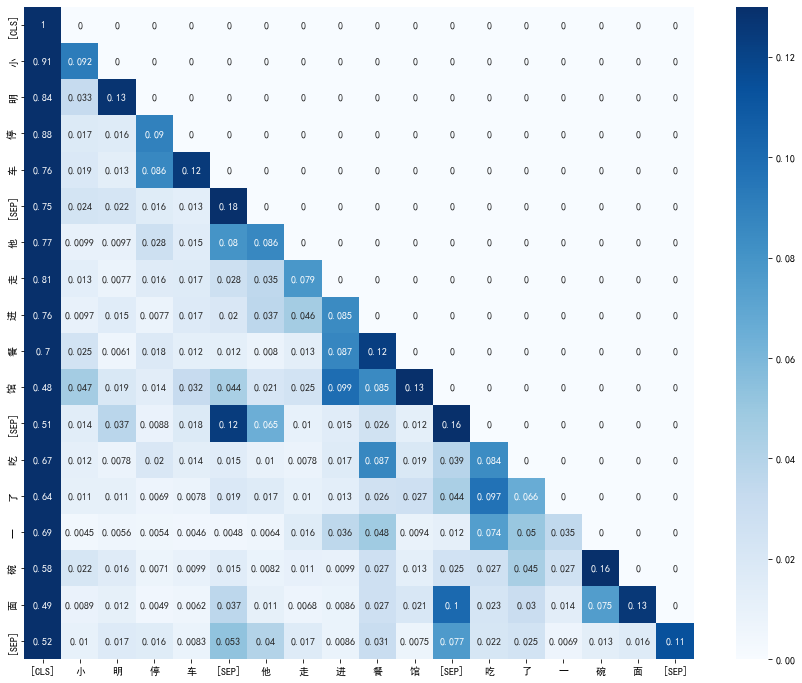

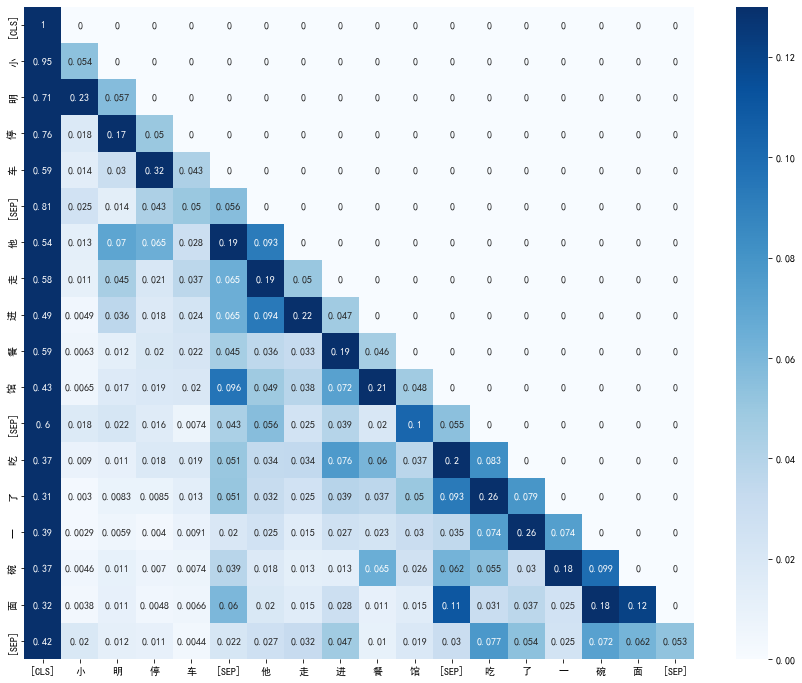

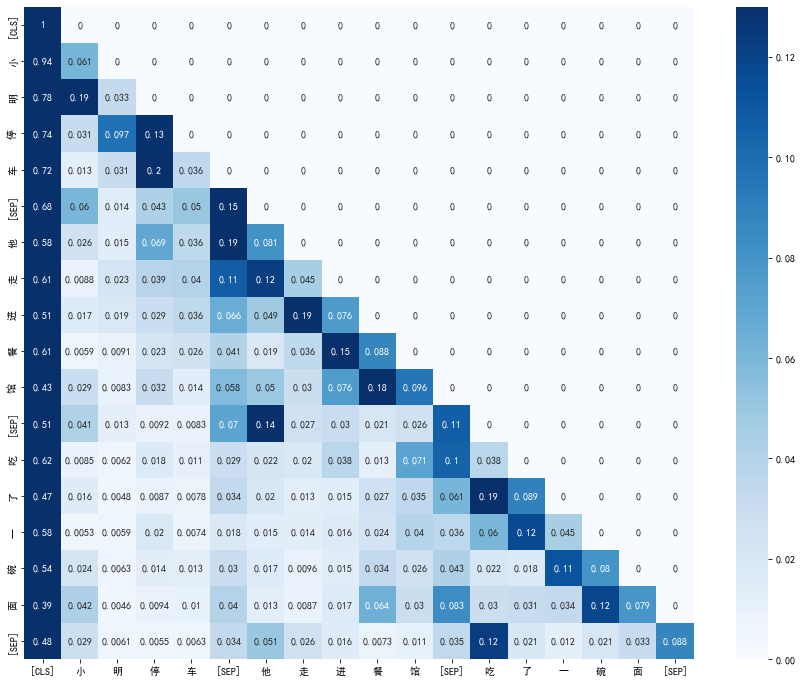

In [125]:

# 设置matplotlib字体以支持中文
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 或者您可以使用其他支持中文的字体
matplotlib.rcParams['font.family']='sans-serif'

# 初始化分词器和模型
tokenizer = BertTokenizer.from_pretrained('F:/project/Attention/gpt2-chinese-cluecorpussmall')
model = GPT2LMHeadModel.from_pretrained('F:/project/Attention/gpt2-chinese-cluecorpussmall', output_attentions=True).eval()

# 输入
sentence1 = "小明停车"
sentence2 = "他走进餐馆"
sentence3 = "吃了一碗面"
marked_sentence = "[CLS] "+ sentence1 + " [SEP]" + sentence2 + " [SEP]" + sentence3 + " [SEP]"

tokenized_text = tokenizer.tokenize(marked_sentence)
tokens = tokenized_text
input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
input_ids = torch.tensor([input_ids])
segments_ids = [1] * len(tokenized_text)
segments_ids = torch.tensor([segments_ids])

# 编码并获取注意力得分
with torch.no_grad():
    outputs = model(input_ids, token_type_ids=segments_ids)
    attentions = outputs.attentions

def plot_attention(attention, tokens):
    # 使用Seaborn绘制热图
    plt.figure(figsize=(15, 12))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, annot=True, cmap='Blues', vmin=0, vmax=0.13)
    plt.show()

# 假设您已经有了tokens和attentions
avg_attention = np.mean([layer[0].detach().numpy() for layer in attentions], axis=0)

# 可视化
plot_attention(avg_attention[11], tokens)
plot_attention(avg_attention[5], tokens)
plot_attention(avg_attention[0], tokens)
